In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
import xgboost

import seaborn as sns

In [2]:
url = "https://raw.githubusercontent.com/jeiloh/SDS384-Project/main/data/merged_df.csv"

# use pandas read_csv function to import the CSV file
merged_df = pd.read_csv(url)

# print the first few rows of the DataFrame
print(merged_df.head())

   Unnamed: 0  Census Tract Start  Day of Week  Hour  num_trips      TractId  \
0           0         48021950300            1    10          1  48021950300   
1           1         48021950300            1    17          1  48021950300   
2           2         48021950300            2    14          1  48021950300   
3           3         48021950300            3    18          1  48021950300   
4           4         48021950300            5    11          1  48021950300   

   State          County  TotalPop   Men  ...  Walk  OtherTransp  WorkAtHome  \
0  Texas  Bastrop County     15255  7591  ...   0.7          1.4         5.8   
1  Texas  Bastrop County     15255  7591  ...   0.7          1.4         5.8   
2  Texas  Bastrop County     15255  7591  ...   0.7          1.4         5.8   
3  Texas  Bastrop County     15255  7591  ...   0.7          1.4         5.8   
4  Texas  Bastrop County     15255  7591  ...   0.7          1.4         5.8   

   MeanCommute  Employed  PrivateWork 

In [3]:
# # create a list of TractIds you want to drop
# tractIds_to_drop = [48453001100]

# # drop rows with these TractIds
# merged_df = merged_df[~merged_df['TractId'].isin(tractIds_to_drop)]

In [4]:
merged_df = merged_df.dropna()

In [5]:
merged_df.shape

(14565, 42)

In [6]:
features = ['Day of Week','Hour','TotalPop', 'Hispanic', 'White', 'Black',
       'Native', 'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment']
dependent_var = ['num_trips']

In [7]:
X = merged_df[features]
y = merged_df[dependent_var]

In [8]:
y = y.values

In [9]:
X = X.dropna().reset_index(drop=True)

In [10]:
X.shape

(14565, 34)

In [11]:
X.index

RangeIndex(start=0, stop=14565, step=1)

In [12]:
from sklearn.preprocessing import StandardScaler

# select all columns except the non-numeric ones
numeric_columns = ['TotalPop', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment']

# standardize the entire dataset
scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# select the categorical variables to be one-hot encoded
categorical_vars = ['Census Tract Start','Day of Week', 'Hour']


In [13]:
X.shape

(14565, 34)

In [14]:
print(X.dtypes)

Day of Week           int64
Hour                  int64
TotalPop            float64
Hispanic            float64
White               float64
Black               float64
Native              float64
Asian               float64
Pacific             float64
VotingAgeCitizen    float64
Income              float64
IncomeErr           float64
IncomePerCap        float64
IncomePerCapErr     float64
Poverty             float64
ChildPoverty        float64
Professional        float64
Service             float64
Office              float64
Construction        float64
Production          float64
Drive               float64
Carpool             float64
Transit             float64
Walk                float64
OtherTransp         float64
WorkAtHome          float64
MeanCommute         float64
Employed            float64
PrivateWork         float64
PublicWork          float64
SelfEmployed        float64
FamilyWork          float64
Unemployment        float64
dtype: object


In [15]:
y.shape

(14565, 1)

In [16]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
# Define the number of folds for cross validation
k = 5

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Create the neural network model
def create_model():
    model = Sequential([
        Dense(100, activation='ReLU', input_shape=(34,)),
        Dense(100, activation='ReLU'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Initialize the KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize the lists to hold the evaluation scores for each fold
val_losses = []
val_maes = []

# Perform k-fold cross validation
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_val)):
    print(f'Fold {fold_idx+1}/{k}')
    
    # Split the data into training and validation sets for this fold
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_val = y_train_val[train_index], y_train_val[test_index]
    
    # Train the neural network on this fold's training data
    model = create_model()
    history = model.fit(X_train, y_train, epochs=1000, batch_size=500, verbose=1, validation_data=(X_val, y_val))
    
    # Evaluate the trained model on this fold's validation data
    val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
    val_losses.append(val_loss)
    val_maes.append(val_mae)
    
    print(f'Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}')


Fold 1/5
Epoch 1/1000
20/20 [==============================] - 1s 18ms/step - loss: 3718662.5000 - mae: 368.7733 - val_loss: 4630613.0000 - val_mae: 385.3683
Epoch 2/1000
20/20 [==============================] - 0s 6ms/step - loss: 3695907.5000 - mae: 366.9641 - val_loss: 4592247.0000 - val_mae: 386.3232
Epoch 3/1000
20/20 [==============================] - 0s 6ms/step - loss: 3640709.2500 - mae: 374.7560 - val_loss: 4513082.5000 - val_mae: 402.7357
Epoch 4/1000
20/20 [==============================] - 0s 6ms/step - loss: 3543663.2500 - mae: 406.6197 - val_loss: 4383339.5000 - val_mae: 451.6874
Epoch 5/1000
20/20 [==============================] - 0s 6ms/step - loss: 3413962.7500 - mae: 472.7028 - val_loss: 4240248.0000 - val_mae: 528.5842
Epoch 6/1000
20/20 [==============================] - 0s 6ms/step - loss: 3295162.5000 - mae: 545.0017 - val_loss: 4119659.5000 - val_mae: 586.6981
Epoch 7/1000
20/20 [==============================] - 0s 6ms/step - loss: 3201537.2500 - mae: 579.4421

Epoch 56/1000
20/20 [==============================] - 0s 7ms/step - loss: 1109819.3750 - mae: 303.0489 - val_loss: 1453846.8750 - val_mae: 311.0495
Epoch 57/1000
20/20 [==============================] - 0s 7ms/step - loss: 1099025.2500 - mae: 300.4274 - val_loss: 1444475.2500 - val_mae: 312.5515
Epoch 58/1000
20/20 [==============================] - 0s 7ms/step - loss: 1089142.5000 - mae: 296.7207 - val_loss: 1430541.0000 - val_mae: 311.3562
Epoch 59/1000
20/20 [==============================] - 0s 7ms/step - loss: 1077134.3750 - mae: 296.2914 - val_loss: 1402921.1250 - val_mae: 303.4384
Epoch 60/1000
20/20 [==============================] - 0s 7ms/step - loss: 1069027.0000 - mae: 291.1313 - val_loss: 1409167.5000 - val_mae: 297.1854
Epoch 61/1000
20/20 [==============================] - 0s 6ms/step - loss: 1059958.5000 - mae: 291.4322 - val_loss: 1376968.1250 - val_mae: 300.4180
Epoch 62/1000
20/20 [==============================] - 0s 6ms/step - loss: 1050695.5000 - mae: 287.3651 - 

20/20 [==============================] - 0s 6ms/step - loss: 691598.5000 - mae: 234.7536 - val_loss: 1002867.1875 - val_mae: 240.7678
Epoch 112/1000
20/20 [==============================] - 0s 6ms/step - loss: 686898.1250 - mae: 224.4559 - val_loss: 1015199.0000 - val_mae: 242.4664
Epoch 113/1000
20/20 [==============================] - 0s 7ms/step - loss: 680496.5625 - mae: 226.8076 - val_loss: 997613.0000 - val_mae: 243.7483
Epoch 114/1000
20/20 [==============================] - 0s 7ms/step - loss: 677302.8125 - mae: 224.0387 - val_loss: 995508.5000 - val_mae: 241.8970
Epoch 115/1000
20/20 [==============================] - 0s 7ms/step - loss: 672772.8125 - mae: 225.7324 - val_loss: 990387.0625 - val_mae: 241.8343
Epoch 116/1000
20/20 [==============================] - 0s 7ms/step - loss: 669725.0625 - mae: 223.6400 - val_loss: 984485.9375 - val_mae: 238.9412
Epoch 117/1000
20/20 [==============================] - 0s 7ms/step - loss: 667823.7500 - mae: 225.5588 - val_loss: 984440.56

20/20 [==============================] - 0s 7ms/step - loss: 563949.8750 - mae: 204.8775 - val_loss: 815331.9375 - val_mae: 224.1171
Epoch 167/1000
20/20 [==============================] - 0s 7ms/step - loss: 568069.3750 - mae: 214.3904 - val_loss: 814975.5625 - val_mae: 238.3447
Epoch 168/1000
20/20 [==============================] - 0s 7ms/step - loss: 562030.5000 - mae: 206.8021 - val_loss: 815637.8125 - val_mae: 223.4960
Epoch 169/1000
20/20 [==============================] - 0s 7ms/step - loss: 562965.3750 - mae: 205.4071 - val_loss: 815989.4375 - val_mae: 224.8392
Epoch 170/1000
20/20 [==============================] - 0s 6ms/step - loss: 562007.3750 - mae: 205.2801 - val_loss: 811529.7500 - val_mae: 223.1957
Epoch 171/1000
20/20 [==============================] - 0s 6ms/step - loss: 563315.4375 - mae: 214.8622 - val_loss: 815354.3125 - val_mae: 228.5623
Epoch 172/1000
20/20 [==============================] - 0s 7ms/step - loss: 559035.7500 - mae: 208.2433 - val_loss: 793005.0625

20/20 [==============================] - 0s 6ms/step - loss: 507291.2500 - mae: 196.2466 - val_loss: 719280.3125 - val_mae: 217.7582
Epoch 222/1000
20/20 [==============================] - 0s 6ms/step - loss: 511883.4375 - mae: 205.1427 - val_loss: 717893.2500 - val_mae: 230.8674
Epoch 223/1000
20/20 [==============================] - 0s 7ms/step - loss: 508688.1875 - mae: 204.1404 - val_loss: 720134.8125 - val_mae: 216.2938
Epoch 224/1000
20/20 [==============================] - 0s 7ms/step - loss: 509248.1562 - mae: 200.2495 - val_loss: 715721.2500 - val_mae: 220.5427
Epoch 225/1000
20/20 [==============================] - 0s 6ms/step - loss: 504992.6875 - mae: 199.4905 - val_loss: 716380.6250 - val_mae: 218.8230
Epoch 226/1000
20/20 [==============================] - 0s 6ms/step - loss: 505957.6250 - mae: 200.8600 - val_loss: 721286.2500 - val_mae: 226.1305
Epoch 227/1000
20/20 [==============================] - 0s 6ms/step - loss: 503308.3125 - mae: 196.4785 - val_loss: 718593.6250

20/20 [==============================] - 0s 6ms/step - loss: 466572.4688 - mae: 195.9688 - val_loss: 657937.5625 - val_mae: 222.2595
Epoch 277/1000
20/20 [==============================] - 0s 6ms/step - loss: 468818.8125 - mae: 196.8780 - val_loss: 660251.1875 - val_mae: 217.7823
Epoch 278/1000
20/20 [==============================] - 0s 6ms/step - loss: 463964.5312 - mae: 194.5988 - val_loss: 653994.8125 - val_mae: 214.9914
Epoch 279/1000
20/20 [==============================] - 0s 7ms/step - loss: 466246.1562 - mae: 196.5108 - val_loss: 650884.0000 - val_mae: 215.0667
Epoch 280/1000
20/20 [==============================] - 0s 7ms/step - loss: 466788.9688 - mae: 198.2838 - val_loss: 657184.9375 - val_mae: 214.4531
Epoch 281/1000
20/20 [==============================] - 0s 7ms/step - loss: 466621.3125 - mae: 200.4861 - val_loss: 652612.8750 - val_mae: 215.0760
Epoch 282/1000
20/20 [==============================] - 0s 7ms/step - loss: 465920.8750 - mae: 199.6751 - val_loss: 650184.8750

20/20 [==============================] - 0s 6ms/step - loss: 428129.7188 - mae: 199.0324 - val_loss: 602020.6875 - val_mae: 224.1732
Epoch 332/1000
20/20 [==============================] - 0s 7ms/step - loss: 425278.4062 - mae: 193.1725 - val_loss: 594445.1875 - val_mae: 209.3924
Epoch 333/1000
20/20 [==============================] - 0s 6ms/step - loss: 424245.9062 - mae: 195.5127 - val_loss: 591726.0000 - val_mae: 212.7619
Epoch 334/1000
20/20 [==============================] - 0s 7ms/step - loss: 423848.4062 - mae: 191.5756 - val_loss: 590092.4375 - val_mae: 211.5838
Epoch 335/1000
20/20 [==============================] - 0s 6ms/step - loss: 422685.5312 - mae: 191.7103 - val_loss: 583711.8750 - val_mae: 209.8606
Epoch 336/1000
20/20 [==============================] - 0s 6ms/step - loss: 423366.8125 - mae: 190.2671 - val_loss: 597487.3750 - val_mae: 210.0136
Epoch 337/1000
20/20 [==============================] - 0s 6ms/step - loss: 420957.5312 - mae: 191.5287 - val_loss: 584636.6875

20/20 [==============================] - 0s 7ms/step - loss: 393829.3750 - mae: 196.9275 - val_loss: 539697.8125 - val_mae: 213.0348
Epoch 387/1000
20/20 [==============================] - 0s 7ms/step - loss: 390340.1875 - mae: 193.8408 - val_loss: 546756.7500 - val_mae: 212.0825
Epoch 388/1000
20/20 [==============================] - 0s 6ms/step - loss: 389695.3438 - mae: 191.5739 - val_loss: 533734.3750 - val_mae: 212.3505
Epoch 389/1000
20/20 [==============================] - 0s 6ms/step - loss: 388933.5938 - mae: 191.1252 - val_loss: 536689.0000 - val_mae: 210.7820
Epoch 390/1000
20/20 [==============================] - 0s 7ms/step - loss: 390657.5625 - mae: 194.0014 - val_loss: 537844.9375 - val_mae: 221.8232
Epoch 391/1000
20/20 [==============================] - 0s 7ms/step - loss: 391844.4062 - mae: 195.6955 - val_loss: 533799.9375 - val_mae: 211.0787
Epoch 392/1000
20/20 [==============================] - 0s 7ms/step - loss: 388692.2500 - mae: 195.3196 - val_loss: 538043.7500

20/20 [==============================] - 0s 6ms/step - loss: 361112.9062 - mae: 190.7676 - val_loss: 493488.5000 - val_mae: 208.7369
Epoch 442/1000
20/20 [==============================] - 0s 6ms/step - loss: 361738.4062 - mae: 191.1260 - val_loss: 496136.5312 - val_mae: 212.6738
Epoch 443/1000
20/20 [==============================] - 0s 6ms/step - loss: 361860.1562 - mae: 192.8521 - val_loss: 494271.1875 - val_mae: 208.5925
Epoch 444/1000
20/20 [==============================] - 0s 7ms/step - loss: 362784.6875 - mae: 194.3068 - val_loss: 491999.5312 - val_mae: 209.3128
Epoch 445/1000
20/20 [==============================] - 0s 6ms/step - loss: 359754.0625 - mae: 190.1621 - val_loss: 490932.2500 - val_mae: 208.9556
Epoch 446/1000
20/20 [==============================] - 0s 7ms/step - loss: 360077.5625 - mae: 193.2917 - val_loss: 498390.2188 - val_mae: 225.8942
Epoch 447/1000
20/20 [==============================] - 0s 7ms/step - loss: 361758.4375 - mae: 196.0280 - val_loss: 498247.3438

20/20 [==============================] - 0s 6ms/step - loss: 336405.8438 - mae: 193.2475 - val_loss: 464338.5000 - val_mae: 213.3454
Epoch 497/1000
20/20 [==============================] - 0s 7ms/step - loss: 336830.3125 - mae: 193.6606 - val_loss: 463967.8438 - val_mae: 215.3601
Epoch 498/1000
20/20 [==============================] - 0s 7ms/step - loss: 334620.1562 - mae: 189.9844 - val_loss: 460388.9062 - val_mae: 208.5376
Epoch 499/1000
20/20 [==============================] - 0s 7ms/step - loss: 335679.4688 - mae: 190.8320 - val_loss: 459060.3125 - val_mae: 206.9170
Epoch 500/1000
20/20 [==============================] - 0s 7ms/step - loss: 338160.2812 - mae: 190.6474 - val_loss: 456931.3750 - val_mae: 208.3013
Epoch 501/1000
20/20 [==============================] - 0s 7ms/step - loss: 333912.0000 - mae: 191.3898 - val_loss: 458816.5625 - val_mae: 209.6898
Epoch 502/1000
20/20 [==============================] - 0s 7ms/step - loss: 334370.4688 - mae: 189.8233 - val_loss: 460438.2188

20/20 [==============================] - 0s 6ms/step - loss: 313829.5312 - mae: 185.5476 - val_loss: 438644.9375 - val_mae: 204.8079
Epoch 552/1000
20/20 [==============================] - 0s 6ms/step - loss: 311811.9688 - mae: 186.8611 - val_loss: 431914.8125 - val_mae: 203.1734
Epoch 553/1000
20/20 [==============================] - 0s 6ms/step - loss: 311286.9688 - mae: 186.0423 - val_loss: 432049.2812 - val_mae: 203.9010
Epoch 554/1000
20/20 [==============================] - 0s 6ms/step - loss: 312864.4375 - mae: 187.7665 - val_loss: 435393.2500 - val_mae: 202.8592
Epoch 555/1000
20/20 [==============================] - 0s 6ms/step - loss: 312371.0625 - mae: 188.2684 - val_loss: 425129.6875 - val_mae: 202.4568
Epoch 556/1000
20/20 [==============================] - 0s 6ms/step - loss: 311698.9062 - mae: 185.5843 - val_loss: 434911.9375 - val_mae: 205.3160
Epoch 557/1000
20/20 [==============================] - 0s 7ms/step - loss: 309328.1875 - mae: 185.0127 - val_loss: 424121.3125

20/20 [==============================] - 0s 6ms/step - loss: 293091.7812 - mae: 183.2648 - val_loss: 403118.5312 - val_mae: 198.8450
Epoch 607/1000
20/20 [==============================] - 0s 7ms/step - loss: 290286.0000 - mae: 181.4170 - val_loss: 404249.7812 - val_mae: 198.3882
Epoch 608/1000
20/20 [==============================] - 0s 6ms/step - loss: 295642.9375 - mae: 186.2859 - val_loss: 411824.3750 - val_mae: 206.0340
Epoch 609/1000
20/20 [==============================] - 0s 7ms/step - loss: 289837.3125 - mae: 183.2714 - val_loss: 411640.3125 - val_mae: 200.0314
Epoch 610/1000
20/20 [==============================] - 0s 7ms/step - loss: 289731.5000 - mae: 181.2743 - val_loss: 407037.9688 - val_mae: 200.8737
Epoch 611/1000
20/20 [==============================] - 0s 7ms/step - loss: 289049.1562 - mae: 181.5353 - val_loss: 403637.8750 - val_mae: 199.3294
Epoch 612/1000
20/20 [==============================] - 0s 7ms/step - loss: 290571.1250 - mae: 184.7179 - val_loss: 410803.0625

20/20 [==============================] - 0s 6ms/step - loss: 272468.2500 - mae: 181.6241 - val_loss: 386747.6562 - val_mae: 205.4236
Epoch 662/1000
20/20 [==============================] - 0s 7ms/step - loss: 271475.1562 - mae: 180.2389 - val_loss: 388754.1562 - val_mae: 200.2301
Epoch 663/1000
20/20 [==============================] - 0s 7ms/step - loss: 273132.6250 - mae: 180.3439 - val_loss: 395551.6875 - val_mae: 204.0480
Epoch 664/1000
20/20 [==============================] - 0s 7ms/step - loss: 277909.8750 - mae: 181.8035 - val_loss: 387889.5312 - val_mae: 201.1431
Epoch 665/1000
20/20 [==============================] - 0s 7ms/step - loss: 272999.3750 - mae: 181.8285 - val_loss: 386821.0000 - val_mae: 197.7254
Epoch 666/1000
20/20 [==============================] - 0s 6ms/step - loss: 268381.5625 - mae: 177.0367 - val_loss: 382566.0000 - val_mae: 196.3929
Epoch 667/1000
20/20 [==============================] - 0s 6ms/step - loss: 269623.4062 - mae: 178.5887 - val_loss: 383420.2812

20/20 [==============================] - 0s 6ms/step - loss: 255195.4062 - mae: 178.4109 - val_loss: 365475.5312 - val_mae: 199.7684
Epoch 717/1000
20/20 [==============================] - 0s 6ms/step - loss: 253295.7969 - mae: 175.6122 - val_loss: 367753.5000 - val_mae: 195.8748
Epoch 718/1000
20/20 [==============================] - 0s 7ms/step - loss: 252905.6875 - mae: 176.4441 - val_loss: 372810.6562 - val_mae: 203.1224
Epoch 719/1000
20/20 [==============================] - 0s 7ms/step - loss: 253880.4844 - mae: 176.5633 - val_loss: 366248.7500 - val_mae: 197.2165
Epoch 720/1000
20/20 [==============================] - 0s 7ms/step - loss: 253354.4688 - mae: 176.9351 - val_loss: 371583.9062 - val_mae: 195.8052
Epoch 721/1000
20/20 [==============================] - 0s 7ms/step - loss: 251770.4219 - mae: 175.9856 - val_loss: 370492.6875 - val_mae: 196.9458
Epoch 722/1000
20/20 [==============================] - 0s 7ms/step - loss: 252046.1094 - mae: 176.1270 - val_loss: 369687.6875

20/20 [==============================] - 0s 6ms/step - loss: 242953.0469 - mae: 184.4321 - val_loss: 362156.9688 - val_mae: 199.4893
Epoch 772/1000
20/20 [==============================] - 0s 6ms/step - loss: 239181.3594 - mae: 178.9894 - val_loss: 366914.6875 - val_mae: 204.4191
Epoch 773/1000
20/20 [==============================] - 0s 7ms/step - loss: 240177.7812 - mae: 176.5191 - val_loss: 353140.9375 - val_mae: 200.3611
Epoch 774/1000
20/20 [==============================] - 0s 7ms/step - loss: 238682.1562 - mae: 180.3540 - val_loss: 354920.0000 - val_mae: 196.7395
Epoch 775/1000
20/20 [==============================] - 0s 6ms/step - loss: 237948.7656 - mae: 175.5539 - val_loss: 366699.3125 - val_mae: 202.4966
Epoch 776/1000
20/20 [==============================] - 0s 6ms/step - loss: 236275.6406 - mae: 173.4811 - val_loss: 351358.4375 - val_mae: 192.9564
Epoch 777/1000
20/20 [==============================] - 0s 6ms/step - loss: 237814.6406 - mae: 174.9691 - val_loss: 355819.3438

20/20 [==============================] - 0s 6ms/step - loss: 222805.3281 - mae: 172.3560 - val_loss: 337612.7812 - val_mae: 191.0316
Epoch 827/1000
20/20 [==============================] - 0s 7ms/step - loss: 222071.5781 - mae: 172.1559 - val_loss: 344681.9062 - val_mae: 198.0131
Epoch 828/1000
20/20 [==============================] - 0s 6ms/step - loss: 221340.4531 - mae: 171.0682 - val_loss: 341796.9062 - val_mae: 191.0032
Epoch 829/1000
20/20 [==============================] - 0s 7ms/step - loss: 221975.5938 - mae: 170.8990 - val_loss: 342970.0938 - val_mae: 194.2204
Epoch 830/1000
20/20 [==============================] - 0s 7ms/step - loss: 222051.6250 - mae: 171.8932 - val_loss: 334867.0938 - val_mae: 193.3376
Epoch 831/1000
20/20 [==============================] - 0s 7ms/step - loss: 221151.2969 - mae: 171.0855 - val_loss: 339279.9375 - val_mae: 193.5656
Epoch 832/1000
20/20 [==============================] - 0s 7ms/step - loss: 222623.2031 - mae: 170.7953 - val_loss: 351812.7500

20/20 [==============================] - 0s 7ms/step - loss: 207427.1094 - mae: 167.6707 - val_loss: 325893.6250 - val_mae: 193.0830
Epoch 882/1000
20/20 [==============================] - 0s 6ms/step - loss: 209779.0469 - mae: 169.2056 - val_loss: 323409.1562 - val_mae: 189.5102
Epoch 883/1000
20/20 [==============================] - 0s 7ms/step - loss: 207622.6094 - mae: 166.5114 - val_loss: 331892.6875 - val_mae: 194.8843
Epoch 884/1000
20/20 [==============================] - 0s 7ms/step - loss: 208151.8594 - mae: 167.3931 - val_loss: 325948.5312 - val_mae: 191.5552
Epoch 885/1000
20/20 [==============================] - 0s 7ms/step - loss: 207921.8906 - mae: 168.0874 - val_loss: 316367.3438 - val_mae: 187.7105
Epoch 886/1000
20/20 [==============================] - 0s 7ms/step - loss: 207326.0938 - mae: 168.4454 - val_loss: 323963.8125 - val_mae: 194.8038
Epoch 887/1000
20/20 [==============================] - 0s 6ms/step - loss: 207851.1719 - mae: 170.5424 - val_loss: 325622.8125

20/20 [==============================] - 0s 7ms/step - loss: 196253.6094 - mae: 162.8120 - val_loss: 318770.7188 - val_mae: 193.1535
Epoch 937/1000
20/20 [==============================] - 0s 7ms/step - loss: 197712.4531 - mae: 164.5500 - val_loss: 311756.7188 - val_mae: 190.1399
Epoch 938/1000
20/20 [==============================] - 0s 7ms/step - loss: 195351.6094 - mae: 162.9126 - val_loss: 316030.7500 - val_mae: 187.1368
Epoch 939/1000
20/20 [==============================] - 0s 6ms/step - loss: 198198.3750 - mae: 166.2847 - val_loss: 315436.3438 - val_mae: 191.2675
Epoch 940/1000
20/20 [==============================] - 0s 6ms/step - loss: 196802.2812 - mae: 163.1605 - val_loss: 310124.7812 - val_mae: 189.1654
Epoch 941/1000
20/20 [==============================] - 0s 7ms/step - loss: 198483.6875 - mae: 165.5119 - val_loss: 313024.6562 - val_mae: 189.1627
Epoch 942/1000
20/20 [==============================] - 0s 7ms/step - loss: 202926.9062 - mae: 165.9682 - val_loss: 318771.2188

20/20 [==============================] - 0s 6ms/step - loss: 189655.1250 - mae: 167.2722 - val_loss: 299519.9375 - val_mae: 185.3232
Epoch 992/1000
20/20 [==============================] - 0s 6ms/step - loss: 188183.6719 - mae: 162.8279 - val_loss: 307189.0312 - val_mae: 196.4352
Epoch 993/1000
20/20 [==============================] - 0s 7ms/step - loss: 187791.7500 - mae: 164.5615 - val_loss: 311157.9062 - val_mae: 189.6880
Epoch 994/1000
20/20 [==============================] - 0s 7ms/step - loss: 187203.9688 - mae: 162.7870 - val_loss: 299071.4375 - val_mae: 184.3540
Epoch 995/1000
20/20 [==============================] - 0s 6ms/step - loss: 188722.4375 - mae: 165.7262 - val_loss: 309085.2500 - val_mae: 186.6496
Epoch 996/1000
20/20 [==============================] - 0s 7ms/step - loss: 187279.8281 - mae: 164.1430 - val_loss: 300439.9375 - val_mae: 190.2614
Epoch 997/1000
20/20 [==============================] - 0s 7ms/step - loss: 187421.8438 - mae: 162.1354 - val_loss: 298373.9375

20/20 [==============================] - 0s 6ms/step - loss: 1323037.1250 - mae: 342.9690 - val_loss: 1055643.2500 - val_mae: 303.6581
Epoch 46/1000
20/20 [==============================] - 0s 6ms/step - loss: 1306665.2500 - mae: 332.3372 - val_loss: 1040854.2500 - val_mae: 300.5680
Epoch 47/1000
20/20 [==============================] - 0s 6ms/step - loss: 1299866.8750 - mae: 332.5154 - val_loss: 1041795.0000 - val_mae: 302.1487
Epoch 48/1000
20/20 [==============================] - 0s 6ms/step - loss: 1284148.6250 - mae: 331.4167 - val_loss: 1026762.0000 - val_mae: 301.0214
Epoch 49/1000
20/20 [==============================] - 0s 7ms/step - loss: 1273163.7500 - mae: 331.7534 - val_loss: 1018473.1250 - val_mae: 297.4161
Epoch 50/1000
20/20 [==============================] - 0s 6ms/step - loss: 1264570.8750 - mae: 327.7751 - val_loss: 1009165.8750 - val_mae: 301.4459
Epoch 51/1000
20/20 [==============================] - 0s 7ms/step - loss: 1249525.5000 - mae: 324.9491 - val_loss: 1004

20/20 [==============================] - 0s 6ms/step - loss: 814470.6250 - mae: 242.8203 - val_loss: 671143.5000 - val_mae: 220.6456
Epoch 101/1000
20/20 [==============================] - 0s 6ms/step - loss: 810537.8125 - mae: 242.8754 - val_loss: 664138.0000 - val_mae: 219.6092
Epoch 102/1000
20/20 [==============================] - 0s 6ms/step - loss: 808053.7500 - mae: 249.7074 - val_loss: 664644.3125 - val_mae: 222.9962
Epoch 103/1000
20/20 [==============================] - 0s 6ms/step - loss: 799331.7500 - mae: 241.3956 - val_loss: 661929.3750 - val_mae: 218.1544
Epoch 104/1000
20/20 [==============================] - 0s 7ms/step - loss: 794230.8125 - mae: 247.4814 - val_loss: 658048.3125 - val_mae: 219.8393
Epoch 105/1000
20/20 [==============================] - 0s 7ms/step - loss: 789816.3125 - mae: 246.1680 - val_loss: 658568.5000 - val_mae: 222.9268
Epoch 106/1000
20/20 [==============================] - 0s 7ms/step - loss: 785801.4375 - mae: 239.5328 - val_loss: 649519.8750

20/20 [==============================] - 0s 6ms/step - loss: 648672.1250 - mae: 228.3844 - val_loss: 612303.6875 - val_mae: 211.7270
Epoch 156/1000
20/20 [==============================] - 0s 7ms/step - loss: 647050.3750 - mae: 225.5649 - val_loss: 612333.9375 - val_mae: 215.1912
Epoch 157/1000
20/20 [==============================] - 0s 6ms/step - loss: 644840.8125 - mae: 226.6731 - val_loss: 612932.8750 - val_mae: 217.2924
Epoch 158/1000
20/20 [==============================] - 0s 6ms/step - loss: 644849.6875 - mae: 228.1566 - val_loss: 613632.0000 - val_mae: 213.8527
Epoch 159/1000
20/20 [==============================] - 0s 6ms/step - loss: 642763.6875 - mae: 224.0009 - val_loss: 613863.6875 - val_mae: 212.0726
Epoch 160/1000
20/20 [==============================] - 0s 7ms/step - loss: 645041.8125 - mae: 232.9666 - val_loss: 612234.3750 - val_mae: 219.7799
Epoch 161/1000
20/20 [==============================] - 0s 7ms/step - loss: 641355.1875 - mae: 228.9068 - val_loss: 609562.1250

20/20 [==============================] - 0s 6ms/step - loss: 587746.5625 - mae: 220.8863 - val_loss: 578462.6250 - val_mae: 210.7684
Epoch 211/1000
20/20 [==============================] - 0s 6ms/step - loss: 586998.3750 - mae: 219.9198 - val_loss: 578700.9375 - val_mae: 211.1393
Epoch 212/1000
20/20 [==============================] - 0s 7ms/step - loss: 591532.1250 - mae: 222.8894 - val_loss: 576736.8750 - val_mae: 208.7826
Epoch 213/1000
20/20 [==============================] - 0s 7ms/step - loss: 586517.0625 - mae: 221.5626 - val_loss: 575536.0625 - val_mae: 216.3383
Epoch 214/1000
20/20 [==============================] - 0s 7ms/step - loss: 585181.6875 - mae: 224.1301 - val_loss: 575726.9375 - val_mae: 208.2056
Epoch 215/1000
20/20 [==============================] - 0s 7ms/step - loss: 589590.2500 - mae: 221.5211 - val_loss: 577729.9375 - val_mae: 209.6539
Epoch 216/1000
20/20 [==============================] - 0s 6ms/step - loss: 585006.2500 - mae: 222.1361 - val_loss: 570475.8125

20/20 [==============================] - 0s 6ms/step - loss: 532419.5000 - mae: 217.3580 - val_loss: 532711.2500 - val_mae: 207.1092
Epoch 266/1000
20/20 [==============================] - 0s 7ms/step - loss: 535323.0625 - mae: 220.1309 - val_loss: 538913.8750 - val_mae: 227.7926
Epoch 267/1000
20/20 [==============================] - 0s 6ms/step - loss: 532002.4375 - mae: 221.6806 - val_loss: 529936.9375 - val_mae: 206.4227
Epoch 268/1000
20/20 [==============================] - 0s 6ms/step - loss: 528949.6875 - mae: 216.1624 - val_loss: 528077.7500 - val_mae: 206.3392
Epoch 269/1000
20/20 [==============================] - 0s 6ms/step - loss: 532489.5625 - mae: 217.8966 - val_loss: 532249.0000 - val_mae: 208.8229
Epoch 270/1000
20/20 [==============================] - 0s 7ms/step - loss: 525978.0625 - mae: 216.2193 - val_loss: 526027.1250 - val_mae: 206.3975
Epoch 271/1000
20/20 [==============================] - 0s 7ms/step - loss: 530133.9375 - mae: 220.7259 - val_loss: 528440.3750

20/20 [==============================] - 0s 6ms/step - loss: 481342.0312 - mae: 217.7099 - val_loss: 484872.2812 - val_mae: 218.6298
Epoch 321/1000
20/20 [==============================] - 0s 6ms/step - loss: 479236.1250 - mae: 214.2349 - val_loss: 480894.0312 - val_mae: 204.4879
Epoch 322/1000
20/20 [==============================] - 0s 7ms/step - loss: 479174.5625 - mae: 209.9966 - val_loss: 477217.5938 - val_mae: 202.8004
Epoch 323/1000
20/20 [==============================] - 0s 7ms/step - loss: 478216.8438 - mae: 212.6501 - val_loss: 475177.1875 - val_mae: 201.6415
Epoch 324/1000
20/20 [==============================] - 0s 7ms/step - loss: 476200.1562 - mae: 209.8546 - val_loss: 480737.8750 - val_mae: 207.8616
Epoch 325/1000
20/20 [==============================] - 0s 7ms/step - loss: 473447.8438 - mae: 210.5361 - val_loss: 475164.9062 - val_mae: 202.2198
Epoch 326/1000
20/20 [==============================] - 0s 7ms/step - loss: 475064.5625 - mae: 208.9563 - val_loss: 478211.5000

20/20 [==============================] - 0s 6ms/step - loss: 440378.3125 - mae: 214.7554 - val_loss: 449594.7812 - val_mae: 205.7761
Epoch 376/1000
20/20 [==============================] - 0s 6ms/step - loss: 438501.3750 - mae: 212.5058 - val_loss: 448274.7188 - val_mae: 200.0859
Epoch 377/1000
20/20 [==============================] - 0s 7ms/step - loss: 434156.3125 - mae: 206.2937 - val_loss: 439474.4688 - val_mae: 203.0835
Epoch 378/1000
20/20 [==============================] - 0s 7ms/step - loss: 435620.4062 - mae: 204.4676 - val_loss: 439489.0312 - val_mae: 198.3577
Epoch 379/1000
20/20 [==============================] - 0s 7ms/step - loss: 433053.5312 - mae: 205.8636 - val_loss: 439931.0312 - val_mae: 204.6079
Epoch 380/1000
20/20 [==============================] - 0s 6ms/step - loss: 432842.4688 - mae: 206.8361 - val_loss: 443051.0000 - val_mae: 198.9577
Epoch 381/1000
20/20 [==============================] - 0s 6ms/step - loss: 432786.0000 - mae: 205.6794 - val_loss: 441215.0625

20/20 [==============================] - 0s 6ms/step - loss: 400054.4688 - mae: 201.4135 - val_loss: 410280.8438 - val_mae: 194.9130
Epoch 431/1000
20/20 [==============================] - 0s 6ms/step - loss: 398643.0000 - mae: 201.0127 - val_loss: 410281.7188 - val_mae: 193.8159
Epoch 432/1000
20/20 [==============================] - 0s 7ms/step - loss: 397865.8438 - mae: 200.1355 - val_loss: 407076.2188 - val_mae: 191.8703
Epoch 433/1000
20/20 [==============================] - 0s 6ms/step - loss: 396582.8125 - mae: 199.9762 - val_loss: 405341.8438 - val_mae: 193.0249
Epoch 434/1000
20/20 [==============================] - 0s 6ms/step - loss: 396594.3125 - mae: 200.9930 - val_loss: 407102.8125 - val_mae: 192.7499
Epoch 435/1000
20/20 [==============================] - 0s 7ms/step - loss: 396678.1875 - mae: 199.8688 - val_loss: 408242.6250 - val_mae: 199.7112
Epoch 436/1000
20/20 [==============================] - 0s 7ms/step - loss: 398806.0000 - mae: 205.5581 - val_loss: 408016.9062

20/20 [==============================] - 0s 7ms/step - loss: 364607.2500 - mae: 190.6193 - val_loss: 373979.5938 - val_mae: 188.1081
Epoch 486/1000
20/20 [==============================] - 0s 7ms/step - loss: 364151.9688 - mae: 193.3041 - val_loss: 372963.2188 - val_mae: 188.9235
Epoch 487/1000
20/20 [==============================] - 0s 7ms/step - loss: 363377.6250 - mae: 193.7880 - val_loss: 372940.5000 - val_mae: 186.1253
Epoch 488/1000
20/20 [==============================] - 0s 7ms/step - loss: 363353.9375 - mae: 194.0624 - val_loss: 371850.8438 - val_mae: 191.2824
Epoch 489/1000
20/20 [==============================] - 0s 7ms/step - loss: 363805.1562 - mae: 193.3857 - val_loss: 375307.7188 - val_mae: 189.0462
Epoch 490/1000
20/20 [==============================] - 0s 6ms/step - loss: 369501.8438 - mae: 196.1260 - val_loss: 383272.5312 - val_mae: 211.4084
Epoch 491/1000
20/20 [==============================] - 0s 6ms/step - loss: 361512.3750 - mae: 202.3363 - val_loss: 368704.2500

20/20 [==============================] - 0s 6ms/step - loss: 336057.2500 - mae: 195.6028 - val_loss: 345488.1250 - val_mae: 186.8289
Epoch 541/1000
20/20 [==============================] - 0s 6ms/step - loss: 336579.2812 - mae: 189.4852 - val_loss: 341751.8750 - val_mae: 185.3296
Epoch 542/1000
20/20 [==============================] - 0s 6ms/step - loss: 336145.2812 - mae: 192.4443 - val_loss: 343571.6562 - val_mae: 181.9578
Epoch 543/1000
20/20 [==============================] - 0s 7ms/step - loss: 332977.7500 - mae: 189.9867 - val_loss: 341316.7188 - val_mae: 185.3115
Epoch 544/1000
20/20 [==============================] - 0s 6ms/step - loss: 332453.4062 - mae: 190.8347 - val_loss: 341846.5312 - val_mae: 184.2892
Epoch 545/1000
20/20 [==============================] - 0s 6ms/step - loss: 330619.9688 - mae: 188.3871 - val_loss: 341444.2812 - val_mae: 182.2498
Epoch 546/1000
20/20 [==============================] - 0s 7ms/step - loss: 330295.7188 - mae: 185.3438 - val_loss: 342142.1250

20/20 [==============================] - 0s 6ms/step - loss: 309669.5938 - mae: 183.6856 - val_loss: 322331.3125 - val_mae: 185.3925
Epoch 596/1000
20/20 [==============================] - 0s 6ms/step - loss: 313207.5312 - mae: 186.2984 - val_loss: 327072.8125 - val_mae: 192.3224
Epoch 597/1000
20/20 [==============================] - 0s 7ms/step - loss: 308853.7812 - mae: 188.2021 - val_loss: 323398.2812 - val_mae: 186.6070
Epoch 598/1000
20/20 [==============================] - 0s 6ms/step - loss: 310306.3750 - mae: 186.2074 - val_loss: 323127.3438 - val_mae: 199.4143
Epoch 599/1000
20/20 [==============================] - 0s 6ms/step - loss: 307800.7812 - mae: 186.9691 - val_loss: 320636.9375 - val_mae: 178.6026
Epoch 600/1000
20/20 [==============================] - 0s 7ms/step - loss: 307215.1562 - mae: 184.0948 - val_loss: 321549.2188 - val_mae: 185.4891
Epoch 601/1000
20/20 [==============================] - 0s 6ms/step - loss: 308874.0312 - mae: 186.7163 - val_loss: 321960.0938

20/20 [==============================] - 0s 6ms/step - loss: 288475.0000 - mae: 178.3064 - val_loss: 307127.0938 - val_mae: 176.1427
Epoch 651/1000
20/20 [==============================] - 0s 7ms/step - loss: 291545.2812 - mae: 182.0888 - val_loss: 308792.9688 - val_mae: 198.0668
Epoch 652/1000
20/20 [==============================] - 0s 7ms/step - loss: 288051.7188 - mae: 185.1553 - val_loss: 303659.0938 - val_mae: 177.8314
Epoch 653/1000
20/20 [==============================] - 0s 6ms/step - loss: 285332.1562 - mae: 178.0738 - val_loss: 304065.4062 - val_mae: 175.9320
Epoch 654/1000
20/20 [==============================] - 0s 7ms/step - loss: 286490.5312 - mae: 178.4838 - val_loss: 305566.3438 - val_mae: 178.8874
Epoch 655/1000
20/20 [==============================] - 0s 7ms/step - loss: 284417.2188 - mae: 176.8368 - val_loss: 305131.8438 - val_mae: 178.0798
Epoch 656/1000
20/20 [==============================] - 0s 6ms/step - loss: 285704.6250 - mae: 179.1109 - val_loss: 302788.8125

20/20 [==============================] - 0s 6ms/step - loss: 267830.5312 - mae: 177.3989 - val_loss: 289078.8750 - val_mae: 175.8844
Epoch 706/1000
20/20 [==============================] - 0s 7ms/step - loss: 270064.7188 - mae: 174.8595 - val_loss: 290274.3125 - val_mae: 178.6155
Epoch 707/1000
20/20 [==============================] - 0s 6ms/step - loss: 266779.2812 - mae: 177.2740 - val_loss: 287818.4375 - val_mae: 176.6776
Epoch 708/1000
20/20 [==============================] - 0s 6ms/step - loss: 267932.9688 - mae: 179.7469 - val_loss: 286736.2812 - val_mae: 175.2031
Epoch 709/1000
20/20 [==============================] - 0s 7ms/step - loss: 264280.7812 - mae: 175.7869 - val_loss: 289755.5938 - val_mae: 186.0166
Epoch 710/1000
20/20 [==============================] - 0s 7ms/step - loss: 264617.2188 - mae: 176.3621 - val_loss: 285686.5625 - val_mae: 173.5784
Epoch 711/1000
20/20 [==============================] - 0s 6ms/step - loss: 264470.3438 - mae: 173.7017 - val_loss: 286115.0938

20/20 [==============================] - 0s 6ms/step - loss: 247309.5156 - mae: 169.9220 - val_loss: 272975.6875 - val_mae: 170.7334
Epoch 761/1000
20/20 [==============================] - 0s 6ms/step - loss: 249098.4219 - mae: 175.0307 - val_loss: 275407.7500 - val_mae: 183.2631
Epoch 762/1000
20/20 [==============================] - 0s 7ms/step - loss: 248096.2031 - mae: 171.9259 - val_loss: 273786.5625 - val_mae: 171.6728
Epoch 763/1000
20/20 [==============================] - 0s 6ms/step - loss: 246944.0312 - mae: 169.4481 - val_loss: 274514.2188 - val_mae: 172.0541
Epoch 764/1000
20/20 [==============================] - 0s 7ms/step - loss: 249167.7656 - mae: 172.1251 - val_loss: 275815.5938 - val_mae: 191.8796
Epoch 765/1000
20/20 [==============================] - 0s 6ms/step - loss: 250919.8906 - mae: 173.8474 - val_loss: 275328.4062 - val_mae: 174.0563
Epoch 766/1000
20/20 [==============================] - 0s 6ms/step - loss: 248295.7031 - mae: 169.4160 - val_loss: 273554.4688

20/20 [==============================] - 0s 6ms/step - loss: 233331.1250 - mae: 168.7697 - val_loss: 263692.5000 - val_mae: 175.5004
Epoch 816/1000
20/20 [==============================] - 0s 6ms/step - loss: 234034.1250 - mae: 170.5009 - val_loss: 263951.2812 - val_mae: 174.4190
Epoch 817/1000
20/20 [==============================] - 0s 6ms/step - loss: 236240.9844 - mae: 170.7267 - val_loss: 261440.8281 - val_mae: 169.1090
Epoch 818/1000
20/20 [==============================] - 0s 6ms/step - loss: 234367.0156 - mae: 173.8480 - val_loss: 264833.8438 - val_mae: 176.6696
Epoch 819/1000
20/20 [==============================] - 0s 6ms/step - loss: 231331.2500 - mae: 167.6368 - val_loss: 262375.8438 - val_mae: 168.2773
Epoch 820/1000
20/20 [==============================] - 0s 6ms/step - loss: 232331.7656 - mae: 168.1445 - val_loss: 261591.8594 - val_mae: 173.8024
Epoch 821/1000
20/20 [==============================] - 0s 6ms/step - loss: 234853.7656 - mae: 168.4557 - val_loss: 263374.0312

20/20 [==============================] - 0s 6ms/step - loss: 222034.1250 - mae: 171.5308 - val_loss: 257649.8906 - val_mae: 190.0304
Epoch 871/1000
20/20 [==============================] - 0s 6ms/step - loss: 226146.2812 - mae: 172.9202 - val_loss: 254318.3438 - val_mae: 185.3907
Epoch 872/1000
20/20 [==============================] - 0s 6ms/step - loss: 223914.9844 - mae: 167.7553 - val_loss: 251621.7969 - val_mae: 167.1945
Epoch 873/1000
20/20 [==============================] - 0s 7ms/step - loss: 222703.0469 - mae: 173.1735 - val_loss: 252719.2031 - val_mae: 191.5281
Epoch 874/1000
20/20 [==============================] - 0s 7ms/step - loss: 219415.0625 - mae: 167.7710 - val_loss: 250501.1719 - val_mae: 167.6832
Epoch 875/1000
20/20 [==============================] - 0s 7ms/step - loss: 222289.5000 - mae: 167.0735 - val_loss: 254094.8906 - val_mae: 172.2649
Epoch 876/1000
20/20 [==============================] - 0s 6ms/step - loss: 218204.8281 - mae: 163.1032 - val_loss: 249967.6562

20/20 [==============================] - 0s 6ms/step - loss: 209563.1406 - mae: 160.1387 - val_loss: 243019.8906 - val_mae: 169.9673
Epoch 926/1000
20/20 [==============================] - 0s 7ms/step - loss: 209133.1406 - mae: 163.5753 - val_loss: 242031.0625 - val_mae: 166.5821
Epoch 927/1000
20/20 [==============================] - 0s 7ms/step - loss: 208586.9062 - mae: 162.3137 - val_loss: 241182.6094 - val_mae: 164.8190
Epoch 928/1000
20/20 [==============================] - 0s 7ms/step - loss: 208721.9062 - mae: 161.2258 - val_loss: 241706.3906 - val_mae: 166.8457
Epoch 929/1000
20/20 [==============================] - 0s 7ms/step - loss: 210388.1719 - mae: 162.4935 - val_loss: 240463.8906 - val_mae: 166.7192
Epoch 930/1000
20/20 [==============================] - 0s 7ms/step - loss: 206849.1562 - mae: 160.7350 - val_loss: 243088.9062 - val_mae: 165.9742
Epoch 931/1000
20/20 [==============================] - 0s 7ms/step - loss: 211213.4219 - mae: 161.9843 - val_loss: 243983.6094

20/20 [==============================] - 0s 7ms/step - loss: 204158.9062 - mae: 168.1460 - val_loss: 235016.3438 - val_mae: 164.9229
Epoch 981/1000
20/20 [==============================] - 0s 7ms/step - loss: 199659.7500 - mae: 160.0233 - val_loss: 232647.2188 - val_mae: 164.1148
Epoch 982/1000
20/20 [==============================] - 0s 7ms/step - loss: 200903.8750 - mae: 159.8248 - val_loss: 235197.5156 - val_mae: 165.1633
Epoch 983/1000
20/20 [==============================] - 0s 6ms/step - loss: 198818.2656 - mae: 157.6975 - val_loss: 233118.3750 - val_mae: 165.3819
Epoch 984/1000
20/20 [==============================] - 0s 6ms/step - loss: 199662.5469 - mae: 162.5694 - val_loss: 233303.3438 - val_mae: 165.2156
Epoch 985/1000
20/20 [==============================] - 0s 6ms/step - loss: 199467.8438 - mae: 157.8892 - val_loss: 235337.7656 - val_mae: 173.3569
Epoch 986/1000
20/20 [==============================] - 0s 7ms/step - loss: 201402.2500 - mae: 164.6963 - val_loss: 235329.0781

20/20 [==============================] - 0s 6ms/step - loss: 1563437.3750 - mae: 398.8440 - val_loss: 1438335.1250 - val_mae: 407.1070
Epoch 35/1000
20/20 [==============================] - 0s 7ms/step - loss: 1543371.2500 - mae: 385.1348 - val_loss: 1418009.2500 - val_mae: 398.4655
Epoch 36/1000
20/20 [==============================] - 0s 6ms/step - loss: 1525271.7500 - mae: 388.3201 - val_loss: 1401165.1250 - val_mae: 402.9807
Epoch 37/1000
20/20 [==============================] - 0s 6ms/step - loss: 1504674.3750 - mae: 384.8669 - val_loss: 1382020.1250 - val_mae: 390.1905
Epoch 38/1000
20/20 [==============================] - 0s 5ms/step - loss: 1484764.5000 - mae: 373.0371 - val_loss: 1362027.0000 - val_mae: 384.4028
Epoch 39/1000
20/20 [==============================] - 0s 6ms/step - loss: 1477788.5000 - mae: 369.4990 - val_loss: 1350423.6250 - val_mae: 389.7636
Epoch 40/1000
20/20 [==============================] - 0s 6ms/step - loss: 1455991.7500 - mae: 369.9664 - val_loss: 1330

20/20 [==============================] - 0s 6ms/step - loss: 901881.5000 - mae: 251.2471 - val_loss: 808149.5000 - val_mae: 259.0502
Epoch 90/1000
20/20 [==============================] - 0s 7ms/step - loss: 886575.3750 - mae: 252.0745 - val_loss: 813222.7500 - val_mae: 259.3770
Epoch 91/1000
20/20 [==============================] - 0s 6ms/step - loss: 876789.3750 - mae: 246.9050 - val_loss: 797657.8750 - val_mae: 253.1406
Epoch 92/1000
20/20 [==============================] - 0s 6ms/step - loss: 868111.3750 - mae: 244.7170 - val_loss: 791150.8125 - val_mae: 257.5496
Epoch 93/1000
20/20 [==============================] - 0s 6ms/step - loss: 861089.2500 - mae: 246.4954 - val_loss: 789931.3750 - val_mae: 262.6465
Epoch 94/1000
20/20 [==============================] - 0s 6ms/step - loss: 858443.0000 - mae: 248.2065 - val_loss: 788404.1875 - val_mae: 261.8339
Epoch 95/1000
20/20 [==============================] - 0s 6ms/step - loss: 847452.1250 - mae: 250.3189 - val_loss: 773017.2500 - val

20/20 [==============================] - 0s 6ms/step - loss: 659331.7500 - mae: 218.5497 - val_loss: 664353.6250 - val_mae: 232.5937
Epoch 145/1000
20/20 [==============================] - 0s 6ms/step - loss: 659661.3125 - mae: 217.8184 - val_loss: 657880.6250 - val_mae: 227.5303
Epoch 146/1000
20/20 [==============================] - 0s 7ms/step - loss: 655329.2500 - mae: 214.8404 - val_loss: 664922.1250 - val_mae: 230.5562
Epoch 147/1000
20/20 [==============================] - 0s 6ms/step - loss: 657052.5625 - mae: 218.7473 - val_loss: 661410.1250 - val_mae: 220.6382
Epoch 148/1000
20/20 [==============================] - 0s 7ms/step - loss: 655945.2500 - mae: 215.0380 - val_loss: 654149.0000 - val_mae: 227.8927
Epoch 149/1000
20/20 [==============================] - 0s 7ms/step - loss: 652530.6875 - mae: 217.8228 - val_loss: 657563.9375 - val_mae: 220.3207
Epoch 150/1000
20/20 [==============================] - 0s 7ms/step - loss: 651654.5625 - mae: 215.7911 - val_loss: 654290.8125

20/20 [==============================] - 0s 6ms/step - loss: 600194.9375 - mae: 203.0862 - val_loss: 624598.5000 - val_mae: 209.3344
Epoch 200/1000
20/20 [==============================] - 0s 6ms/step - loss: 601281.3750 - mae: 200.7579 - val_loss: 622863.7500 - val_mae: 208.6300
Epoch 201/1000
20/20 [==============================] - 0s 6ms/step - loss: 600538.4375 - mae: 203.2711 - val_loss: 622135.3750 - val_mae: 212.7003
Epoch 202/1000
20/20 [==============================] - 0s 6ms/step - loss: 602073.7500 - mae: 205.0215 - val_loss: 623616.4375 - val_mae: 211.6371
Epoch 203/1000
20/20 [==============================] - 0s 6ms/step - loss: 600444.5625 - mae: 203.5912 - val_loss: 622233.8125 - val_mae: 207.3281
Epoch 204/1000
20/20 [==============================] - 0s 7ms/step - loss: 595659.5000 - mae: 200.0642 - val_loss: 618865.4375 - val_mae: 209.8317
Epoch 205/1000
20/20 [==============================] - 0s 6ms/step - loss: 596628.1875 - mae: 202.7705 - val_loss: 619590.2500

20/20 [==============================] - 0s 6ms/step - loss: 547143.1250 - mae: 197.5597 - val_loss: 590356.8125 - val_mae: 208.5338
Epoch 255/1000
20/20 [==============================] - 0s 6ms/step - loss: 546914.3750 - mae: 196.1728 - val_loss: 580040.2500 - val_mae: 203.4444
Epoch 256/1000
20/20 [==============================] - 0s 6ms/step - loss: 545131.5625 - mae: 196.8550 - val_loss: 584009.5000 - val_mae: 212.0779
Epoch 257/1000
20/20 [==============================] - 0s 6ms/step - loss: 543653.5000 - mae: 198.6718 - val_loss: 581747.5625 - val_mae: 205.8589
Epoch 258/1000
20/20 [==============================] - 0s 6ms/step - loss: 545151.2500 - mae: 205.0011 - val_loss: 580672.0000 - val_mae: 208.7324
Epoch 259/1000
20/20 [==============================] - 0s 6ms/step - loss: 540638.8125 - mae: 197.4916 - val_loss: 581382.3750 - val_mae: 205.6732
Epoch 260/1000
20/20 [==============================] - 0s 6ms/step - loss: 541639.3125 - mae: 202.0421 - val_loss: 580108.5000

20/20 [==============================] - 0s 6ms/step - loss: 482865.9375 - mae: 191.5262 - val_loss: 544222.3125 - val_mae: 205.4316
Epoch 310/1000
20/20 [==============================] - 0s 6ms/step - loss: 481777.2812 - mae: 192.4120 - val_loss: 543868.6250 - val_mae: 201.3829
Epoch 311/1000
20/20 [==============================] - 0s 7ms/step - loss: 481376.9375 - mae: 192.0381 - val_loss: 536389.4375 - val_mae: 208.8989
Epoch 312/1000
20/20 [==============================] - 0s 6ms/step - loss: 480013.9688 - mae: 192.6756 - val_loss: 536779.6250 - val_mae: 204.4830
Epoch 313/1000
20/20 [==============================] - 0s 6ms/step - loss: 478624.4688 - mae: 191.2678 - val_loss: 533405.4375 - val_mae: 202.2510
Epoch 314/1000
20/20 [==============================] - 0s 6ms/step - loss: 482443.4688 - mae: 196.8608 - val_loss: 541616.1250 - val_mae: 202.0706
Epoch 315/1000
20/20 [==============================] - 0s 6ms/step - loss: 478034.9062 - mae: 195.2246 - val_loss: 539990.8750

20/20 [==============================] - 0s 6ms/step - loss: 417033.3750 - mae: 183.7405 - val_loss: 504656.6562 - val_mae: 201.3011
Epoch 365/1000
20/20 [==============================] - 0s 6ms/step - loss: 418365.2812 - mae: 186.7029 - val_loss: 504602.0000 - val_mae: 199.8717
Epoch 366/1000
20/20 [==============================] - 0s 6ms/step - loss: 419915.1250 - mae: 185.5783 - val_loss: 503320.4375 - val_mae: 201.3915
Epoch 367/1000
20/20 [==============================] - 0s 6ms/step - loss: 414993.4062 - mae: 184.6730 - val_loss: 503830.6875 - val_mae: 199.3873
Epoch 368/1000
20/20 [==============================] - 0s 6ms/step - loss: 415224.9375 - mae: 185.4521 - val_loss: 512638.8750 - val_mae: 204.8915
Epoch 369/1000
20/20 [==============================] - 0s 6ms/step - loss: 413404.4688 - mae: 185.3957 - val_loss: 503490.0312 - val_mae: 200.1196
Epoch 370/1000
20/20 [==============================] - 0s 7ms/step - loss: 414955.4375 - mae: 184.3756 - val_loss: 499179.0000

20/20 [==============================] - 0s 6ms/step - loss: 370424.1875 - mae: 186.1765 - val_loss: 481937.2188 - val_mae: 201.3926
Epoch 420/1000
20/20 [==============================] - 0s 7ms/step - loss: 368149.1562 - mae: 181.5565 - val_loss: 482842.6875 - val_mae: 200.8142
Epoch 421/1000
20/20 [==============================] - 0s 6ms/step - loss: 364721.4688 - mae: 180.4401 - val_loss: 482312.6875 - val_mae: 201.0106
Epoch 422/1000
20/20 [==============================] - 0s 6ms/step - loss: 364142.2500 - mae: 178.8204 - val_loss: 480024.1875 - val_mae: 200.4392
Epoch 423/1000
20/20 [==============================] - 0s 7ms/step - loss: 363329.2500 - mae: 179.4729 - val_loss: 483004.6250 - val_mae: 201.3619
Epoch 424/1000
20/20 [==============================] - 0s 6ms/step - loss: 361738.8125 - mae: 178.8078 - val_loss: 477629.0000 - val_mae: 199.9725
Epoch 425/1000
20/20 [==============================] - 0s 7ms/step - loss: 362354.0312 - mae: 178.9425 - val_loss: 483200.3125

20/20 [==============================] - 0s 6ms/step - loss: 327839.1250 - mae: 176.1305 - val_loss: 463223.6250 - val_mae: 200.6232
Epoch 475/1000
20/20 [==============================] - 0s 6ms/step - loss: 326147.8125 - mae: 178.2438 - val_loss: 467746.6250 - val_mae: 202.4382
Epoch 476/1000
20/20 [==============================] - 0s 6ms/step - loss: 328612.8750 - mae: 176.7993 - val_loss: 459107.3125 - val_mae: 211.7462
Epoch 477/1000
20/20 [==============================] - 0s 7ms/step - loss: 324485.1875 - mae: 182.0563 - val_loss: 465648.3750 - val_mae: 207.7769
Epoch 478/1000
20/20 [==============================] - 0s 6ms/step - loss: 326722.2812 - mae: 181.1494 - val_loss: 468162.3750 - val_mae: 227.8103
Epoch 479/1000
20/20 [==============================] - 0s 7ms/step - loss: 328398.5625 - mae: 190.2170 - val_loss: 467874.0625 - val_mae: 203.0929
Epoch 480/1000
20/20 [==============================] - 0s 6ms/step - loss: 323881.5938 - mae: 176.6106 - val_loss: 458405.5312

20/20 [==============================] - 0s 6ms/step - loss: 300364.0312 - mae: 173.9057 - val_loss: 442522.2500 - val_mae: 200.7293
Epoch 530/1000
20/20 [==============================] - 0s 6ms/step - loss: 296293.2812 - mae: 172.9287 - val_loss: 451179.7812 - val_mae: 200.6250
Epoch 531/1000
20/20 [==============================] - 0s 6ms/step - loss: 297287.5625 - mae: 175.4014 - val_loss: 443756.3438 - val_mae: 201.7164
Epoch 532/1000
20/20 [==============================] - 0s 6ms/step - loss: 295721.0312 - mae: 174.6695 - val_loss: 443084.2500 - val_mae: 203.7135
Epoch 533/1000
20/20 [==============================] - 0s 6ms/step - loss: 297216.5000 - mae: 174.1951 - val_loss: 448508.5312 - val_mae: 200.9762
Epoch 534/1000
20/20 [==============================] - 0s 7ms/step - loss: 295413.1875 - mae: 182.0685 - val_loss: 443769.0312 - val_mae: 219.8552
Epoch 535/1000
20/20 [==============================] - 0s 7ms/step - loss: 299042.6875 - mae: 189.8791 - val_loss: 439132.0312

20/20 [==============================] - 0s 6ms/step - loss: 274377.7812 - mae: 173.9789 - val_loss: 421627.3438 - val_mae: 209.4591
Epoch 585/1000
20/20 [==============================] - 0s 7ms/step - loss: 278518.4375 - mae: 188.7003 - val_loss: 426004.1250 - val_mae: 202.2039
Epoch 586/1000
20/20 [==============================] - 0s 6ms/step - loss: 272565.9062 - mae: 175.1238 - val_loss: 419329.3438 - val_mae: 197.2518
Epoch 587/1000
20/20 [==============================] - 0s 6ms/step - loss: 272935.2500 - mae: 173.9081 - val_loss: 419412.5625 - val_mae: 198.9000
Epoch 588/1000
20/20 [==============================] - 0s 7ms/step - loss: 271727.2500 - mae: 170.4854 - val_loss: 416962.1250 - val_mae: 199.1428
Epoch 589/1000
20/20 [==============================] - 0s 7ms/step - loss: 271882.2812 - mae: 170.2093 - val_loss: 420764.3438 - val_mae: 199.7455
Epoch 590/1000
20/20 [==============================] - 0s 7ms/step - loss: 273148.7812 - mae: 176.6747 - val_loss: 427329.0938

20/20 [==============================] - 0s 5ms/step - loss: 254577.7344 - mae: 173.0228 - val_loss: 405550.8125 - val_mae: 198.4624
Epoch 640/1000
20/20 [==============================] - 0s 6ms/step - loss: 254319.6562 - mae: 169.0852 - val_loss: 395918.3125 - val_mae: 194.1112
Epoch 641/1000
20/20 [==============================] - 0s 7ms/step - loss: 255159.5938 - mae: 171.6157 - val_loss: 400289.2812 - val_mae: 195.2068
Epoch 642/1000
20/20 [==============================] - 0s 6ms/step - loss: 253838.6875 - mae: 171.1824 - val_loss: 396431.3750 - val_mae: 208.2625
Epoch 643/1000
20/20 [==============================] - 0s 7ms/step - loss: 256437.9375 - mae: 170.3041 - val_loss: 394113.2188 - val_mae: 201.7270
Epoch 644/1000
20/20 [==============================] - 0s 6ms/step - loss: 253683.4688 - mae: 170.5657 - val_loss: 399981.9062 - val_mae: 198.2034
Epoch 645/1000
20/20 [==============================] - 0s 6ms/step - loss: 255041.8281 - mae: 169.2314 - val_loss: 391931.5000

20/20 [==============================] - 0s 7ms/step - loss: 240255.2500 - mae: 173.2702 - val_loss: 376554.8750 - val_mae: 198.3891
Epoch 695/1000
20/20 [==============================] - 0s 6ms/step - loss: 238928.8750 - mae: 166.3889 - val_loss: 377726.3438 - val_mae: 194.9451
Epoch 696/1000
20/20 [==============================] - 0s 6ms/step - loss: 238555.1094 - mae: 167.4174 - val_loss: 372908.7188 - val_mae: 192.4220
Epoch 697/1000
20/20 [==============================] - 0s 6ms/step - loss: 237401.5156 - mae: 166.9498 - val_loss: 370013.1250 - val_mae: 192.2411
Epoch 698/1000
20/20 [==============================] - 0s 7ms/step - loss: 237782.4375 - mae: 165.4153 - val_loss: 374715.2188 - val_mae: 194.0712
Epoch 699/1000
20/20 [==============================] - 0s 6ms/step - loss: 237822.2969 - mae: 167.2857 - val_loss: 374951.7188 - val_mae: 193.0017
Epoch 700/1000
20/20 [==============================] - 0s 7ms/step - loss: 238473.9844 - mae: 165.2466 - val_loss: 366603.6562

20/20 [==============================] - 0s 6ms/step - loss: 223713.6250 - mae: 164.6898 - val_loss: 342415.5000 - val_mae: 188.7121
Epoch 750/1000
20/20 [==============================] - 0s 6ms/step - loss: 223364.5938 - mae: 165.4352 - val_loss: 342460.8438 - val_mae: 190.7774
Epoch 751/1000
20/20 [==============================] - 0s 6ms/step - loss: 221284.8594 - mae: 163.5052 - val_loss: 343098.8750 - val_mae: 188.6435
Epoch 752/1000
20/20 [==============================] - 0s 7ms/step - loss: 222131.0469 - mae: 164.3847 - val_loss: 342741.5625 - val_mae: 192.6947
Epoch 753/1000
20/20 [==============================] - 0s 6ms/step - loss: 223578.0312 - mae: 166.2863 - val_loss: 341689.2188 - val_mae: 189.0361
Epoch 754/1000
20/20 [==============================] - 0s 7ms/step - loss: 226379.0312 - mae: 166.4445 - val_loss: 341480.8438 - val_mae: 192.4541
Epoch 755/1000
20/20 [==============================] - 0s 6ms/step - loss: 222645.8906 - mae: 166.2880 - val_loss: 342474.2500

20/20 [==============================] - 0s 6ms/step - loss: 214095.1250 - mae: 164.2095 - val_loss: 327734.0625 - val_mae: 186.9628
Epoch 805/1000
20/20 [==============================] - 0s 6ms/step - loss: 212906.4219 - mae: 162.9490 - val_loss: 321756.5312 - val_mae: 187.9419
Epoch 806/1000
20/20 [==============================] - 0s 6ms/step - loss: 217612.7969 - mae: 167.2906 - val_loss: 327834.8125 - val_mae: 193.1134
Epoch 807/1000
20/20 [==============================] - 0s 6ms/step - loss: 212928.4844 - mae: 165.9430 - val_loss: 323145.1875 - val_mae: 188.8883
Epoch 808/1000
20/20 [==============================] - 0s 6ms/step - loss: 211232.9062 - mae: 160.5748 - val_loss: 322032.1875 - val_mae: 185.9211
Epoch 809/1000
20/20 [==============================] - 0s 7ms/step - loss: 210532.1875 - mae: 160.7694 - val_loss: 325155.0000 - val_mae: 188.2718
Epoch 810/1000
20/20 [==============================] - 0s 6ms/step - loss: 212736.1094 - mae: 162.6034 - val_loss: 318217.3750

20/20 [==============================] - 0s 7ms/step - loss: 202420.8906 - mae: 159.8979 - val_loss: 310556.0312 - val_mae: 186.1871
Epoch 860/1000
20/20 [==============================] - 0s 7ms/step - loss: 204029.0781 - mae: 160.1592 - val_loss: 304003.5000 - val_mae: 186.0279
Epoch 861/1000
20/20 [==============================] - 0s 7ms/step - loss: 203133.7969 - mae: 161.3953 - val_loss: 310986.8125 - val_mae: 183.4682
Epoch 862/1000
20/20 [==============================] - 0s 7ms/step - loss: 200686.3125 - mae: 159.0823 - val_loss: 314023.7812 - val_mae: 195.6250
Epoch 863/1000
20/20 [==============================] - 0s 6ms/step - loss: 203708.9375 - mae: 162.5131 - val_loss: 311445.0312 - val_mae: 185.4596
Epoch 864/1000
20/20 [==============================] - 0s 6ms/step - loss: 201286.8906 - mae: 160.5611 - val_loss: 304746.4688 - val_mae: 185.6480
Epoch 865/1000
20/20 [==============================] - 0s 6ms/step - loss: 201966.6562 - mae: 158.5794 - val_loss: 305381.5625

20/20 [==============================] - 0s 7ms/step - loss: 195057.3594 - mae: 157.9886 - val_loss: 295199.3125 - val_mae: 182.9427
Epoch 915/1000
20/20 [==============================] - 0s 7ms/step - loss: 191720.9688 - mae: 156.1476 - val_loss: 298562.7812 - val_mae: 183.5415
Epoch 916/1000
20/20 [==============================] - 0s 7ms/step - loss: 194097.8281 - mae: 156.7465 - val_loss: 296447.3125 - val_mae: 187.5010
Epoch 917/1000
20/20 [==============================] - 0s 7ms/step - loss: 196895.2812 - mae: 159.0758 - val_loss: 290942.7188 - val_mae: 181.0051
Epoch 918/1000
20/20 [==============================] - 0s 7ms/step - loss: 192856.9531 - mae: 156.7290 - val_loss: 293917.0938 - val_mae: 181.1152
Epoch 919/1000
20/20 [==============================] - 0s 7ms/step - loss: 193314.7500 - mae: 156.7874 - val_loss: 295138.3125 - val_mae: 181.6589
Epoch 920/1000
20/20 [==============================] - 0s 6ms/step - loss: 195908.8281 - mae: 159.6762 - val_loss: 290545.1250

20/20 [==============================] - 0s 6ms/step - loss: 188453.8125 - mae: 157.9188 - val_loss: 283746.9375 - val_mae: 182.8697
Epoch 970/1000
20/20 [==============================] - 0s 6ms/step - loss: 186678.4688 - mae: 155.1374 - val_loss: 278602.9688 - val_mae: 177.7824
Epoch 971/1000
20/20 [==============================] - 0s 6ms/step - loss: 184638.6250 - mae: 153.9275 - val_loss: 281344.8438 - val_mae: 175.8401
Epoch 972/1000
20/20 [==============================] - 0s 6ms/step - loss: 184784.1406 - mae: 154.1477 - val_loss: 284126.8125 - val_mae: 179.8754
Epoch 973/1000
20/20 [==============================] - 0s 6ms/step - loss: 185325.2344 - mae: 155.0333 - val_loss: 280166.9375 - val_mae: 179.9457
Epoch 974/1000
20/20 [==============================] - 0s 7ms/step - loss: 187811.4375 - mae: 158.3747 - val_loss: 277625.6875 - val_mae: 178.4071
Epoch 975/1000
20/20 [==============================] - 0s 6ms/step - loss: 185979.4375 - mae: 156.5210 - val_loss: 280791.7500

20/20 [==============================] - 0s 7ms/step - loss: 1924108.3750 - mae: 494.2320 - val_loss: 1653828.2500 - val_mae: 491.6883
Epoch 24/1000
20/20 [==============================] - 0s 6ms/step - loss: 1878759.1250 - mae: 487.2476 - val_loss: 1618066.8750 - val_mae: 483.1095
Epoch 25/1000
20/20 [==============================] - 0s 6ms/step - loss: 1837344.5000 - mae: 491.7299 - val_loss: 1583506.8750 - val_mae: 481.7738
Epoch 26/1000
20/20 [==============================] - 0s 6ms/step - loss: 1797431.6250 - mae: 474.7452 - val_loss: 1553151.6250 - val_mae: 468.3989
Epoch 27/1000
20/20 [==============================] - 0s 6ms/step - loss: 1762193.0000 - mae: 476.9352 - val_loss: 1525013.7500 - val_mae: 465.1900
Epoch 28/1000
20/20 [==============================] - 0s 6ms/step - loss: 1727343.0000 - mae: 461.3394 - val_loss: 1496126.0000 - val_mae: 450.4557
Epoch 29/1000
20/20 [==============================] - 0s 6ms/step - loss: 1698057.8750 - mae: 452.7457 - val_loss: 1469

20/20 [==============================] - 0s 7ms/step - loss: 1041679.3750 - mae: 273.6997 - val_loss: 888446.2500 - val_mae: 264.0786
Epoch 79/1000
20/20 [==============================] - 0s 6ms/step - loss: 1032094.3125 - mae: 272.8266 - val_loss: 880426.5000 - val_mae: 262.6243
Epoch 80/1000
20/20 [==============================] - 0s 6ms/step - loss: 1023091.1875 - mae: 267.4616 - val_loss: 879272.5000 - val_mae: 276.2408
Epoch 81/1000
20/20 [==============================] - 0s 6ms/step - loss: 1014888.7500 - mae: 270.4631 - val_loss: 866463.0000 - val_mae: 258.3837
Epoch 82/1000
20/20 [==============================] - 0s 6ms/step - loss: 1007615.8125 - mae: 265.0222 - val_loss: 858566.7500 - val_mae: 258.2050
Epoch 83/1000
20/20 [==============================] - 0s 6ms/step - loss: 1000160.4375 - mae: 270.3239 - val_loss: 856359.0000 - val_mae: 261.8141
Epoch 84/1000
20/20 [==============================] - 0s 6ms/step - loss: 988945.8125 - mae: 260.5555 - val_loss: 847950.8750

20/20 [==============================] - 0s 6ms/step - loss: 704666.7500 - mae: 228.2519 - val_loss: 633503.5625 - val_mae: 221.3754
Epoch 134/1000
20/20 [==============================] - 0s 6ms/step - loss: 700858.8125 - mae: 233.3634 - val_loss: 630723.5625 - val_mae: 223.5998
Epoch 135/1000
20/20 [==============================] - 0s 6ms/step - loss: 698882.2500 - mae: 229.0647 - val_loss: 629842.6875 - val_mae: 228.8195
Epoch 136/1000
20/20 [==============================] - 0s 6ms/step - loss: 694290.6875 - mae: 231.8637 - val_loss: 629176.4375 - val_mae: 231.3661
Epoch 137/1000
20/20 [==============================] - 0s 7ms/step - loss: 690377.4375 - mae: 228.2811 - val_loss: 624587.5000 - val_mae: 220.1321
Epoch 138/1000
20/20 [==============================] - 0s 6ms/step - loss: 686365.0000 - mae: 226.0957 - val_loss: 624435.8125 - val_mae: 222.2345
Epoch 139/1000
20/20 [==============================] - 0s 6ms/step - loss: 685268.1875 - mae: 230.3630 - val_loss: 622146.5625

20/20 [==============================] - 0s 6ms/step - loss: 576868.0625 - mae: 218.8000 - val_loss: 554657.0625 - val_mae: 210.2561
Epoch 189/1000
20/20 [==============================] - 0s 6ms/step - loss: 578844.5625 - mae: 214.2184 - val_loss: 556932.0625 - val_mae: 220.1781
Epoch 190/1000
20/20 [==============================] - 0s 6ms/step - loss: 572137.4375 - mae: 220.8741 - val_loss: 552271.6875 - val_mae: 214.9628
Epoch 191/1000
20/20 [==============================] - 0s 6ms/step - loss: 569563.2500 - mae: 214.8109 - val_loss: 549485.9375 - val_mae: 206.3217
Epoch 192/1000
20/20 [==============================] - 0s 6ms/step - loss: 567872.1875 - mae: 212.0045 - val_loss: 548914.1875 - val_mae: 205.9517
Epoch 193/1000
20/20 [==============================] - 0s 6ms/step - loss: 567585.4375 - mae: 214.3729 - val_loss: 546223.7500 - val_mae: 206.0630
Epoch 194/1000
20/20 [==============================] - 0s 7ms/step - loss: 566009.8750 - mae: 216.8292 - val_loss: 547961.5625

20/20 [==============================] - 0s 6ms/step - loss: 501389.1250 - mae: 207.5630 - val_loss: 508327.9062 - val_mae: 201.7890
Epoch 244/1000
20/20 [==============================] - 0s 6ms/step - loss: 502980.6562 - mae: 210.3082 - val_loss: 507734.6875 - val_mae: 200.5083
Epoch 245/1000
20/20 [==============================] - 0s 6ms/step - loss: 500796.9062 - mae: 207.4611 - val_loss: 507960.3438 - val_mae: 199.7741
Epoch 246/1000
20/20 [==============================] - 0s 6ms/step - loss: 497724.3750 - mae: 205.8101 - val_loss: 508983.0938 - val_mae: 202.8201
Epoch 247/1000
20/20 [==============================] - 0s 7ms/step - loss: 497236.5312 - mae: 208.5918 - val_loss: 505817.8438 - val_mae: 205.4832
Epoch 248/1000
20/20 [==============================] - 0s 6ms/step - loss: 493535.5312 - mae: 205.4253 - val_loss: 503351.0000 - val_mae: 198.7764
Epoch 249/1000
20/20 [==============================] - 0s 6ms/step - loss: 493534.8125 - mae: 203.5380 - val_loss: 506507.6875

20/20 [==============================] - 0s 6ms/step - loss: 435423.7500 - mae: 209.0811 - val_loss: 463449.8438 - val_mae: 208.9201
Epoch 299/1000
20/20 [==============================] - 0s 7ms/step - loss: 432819.2188 - mae: 203.4657 - val_loss: 462331.0000 - val_mae: 205.8675
Epoch 300/1000
20/20 [==============================] - 0s 6ms/step - loss: 429395.3125 - mae: 202.1254 - val_loss: 457025.1250 - val_mae: 199.4564
Epoch 301/1000
20/20 [==============================] - 0s 6ms/step - loss: 432234.7188 - mae: 201.0070 - val_loss: 456676.0312 - val_mae: 198.3990
Epoch 302/1000
20/20 [==============================] - 0s 6ms/step - loss: 428354.6562 - mae: 201.3202 - val_loss: 456291.0625 - val_mae: 197.7696
Epoch 303/1000
20/20 [==============================] - 0s 6ms/step - loss: 425842.6875 - mae: 200.8410 - val_loss: 458464.0938 - val_mae: 204.1496
Epoch 304/1000
20/20 [==============================] - 0s 6ms/step - loss: 425209.0312 - mae: 201.7039 - val_loss: 456366.2188

20/20 [==============================] - 0s 6ms/step - loss: 383281.2812 - mae: 204.7221 - val_loss: 430734.4062 - val_mae: 197.5303
Epoch 354/1000
20/20 [==============================] - 0s 7ms/step - loss: 381430.1562 - mae: 201.4567 - val_loss: 433343.9688 - val_mae: 204.5916
Epoch 355/1000
20/20 [==============================] - 0s 6ms/step - loss: 375462.6250 - mae: 199.2820 - val_loss: 431781.8438 - val_mae: 200.1654
Epoch 356/1000
20/20 [==============================] - 0s 6ms/step - loss: 377120.9375 - mae: 197.4864 - val_loss: 430376.1875 - val_mae: 196.8172
Epoch 357/1000
20/20 [==============================] - 0s 6ms/step - loss: 374904.5312 - mae: 198.5371 - val_loss: 432200.1562 - val_mae: 200.6370
Epoch 358/1000
20/20 [==============================] - 0s 7ms/step - loss: 373744.9688 - mae: 196.7980 - val_loss: 428379.9062 - val_mae: 198.3062
Epoch 359/1000
20/20 [==============================] - 0s 7ms/step - loss: 375340.0938 - mae: 199.8685 - val_loss: 428800.5000

20/20 [==============================] - 0s 7ms/step - loss: 341811.8125 - mae: 195.7040 - val_loss: 414596.3438 - val_mae: 205.5032
Epoch 409/1000
20/20 [==============================] - 0s 6ms/step - loss: 337328.9375 - mae: 196.7951 - val_loss: 412100.4062 - val_mae: 206.2424
Epoch 410/1000
20/20 [==============================] - 0s 6ms/step - loss: 338485.1875 - mae: 203.1711 - val_loss: 410191.5000 - val_mae: 196.6345
Epoch 411/1000
20/20 [==============================] - 0s 6ms/step - loss: 337082.3750 - mae: 199.2921 - val_loss: 408886.9688 - val_mae: 195.6369
Epoch 412/1000
20/20 [==============================] - 0s 6ms/step - loss: 335754.4688 - mae: 193.2349 - val_loss: 407132.1875 - val_mae: 195.3430
Epoch 413/1000
20/20 [==============================] - 0s 6ms/step - loss: 332949.9062 - mae: 192.5265 - val_loss: 410597.8438 - val_mae: 196.9599
Epoch 414/1000
20/20 [==============================] - 0s 6ms/step - loss: 337568.3750 - mae: 193.4734 - val_loss: 407862.8125

20/20 [==============================] - 0s 6ms/step - loss: 311539.6562 - mae: 189.9075 - val_loss: 393568.3750 - val_mae: 196.4721
Epoch 464/1000
20/20 [==============================] - 0s 7ms/step - loss: 307683.1875 - mae: 191.2792 - val_loss: 398885.6250 - val_mae: 195.6950
Epoch 465/1000
20/20 [==============================] - 0s 7ms/step - loss: 306798.6250 - mae: 191.4042 - val_loss: 394107.0000 - val_mae: 193.5683
Epoch 466/1000
20/20 [==============================] - 0s 7ms/step - loss: 304518.6250 - mae: 186.6868 - val_loss: 394446.1250 - val_mae: 192.8474
Epoch 467/1000
20/20 [==============================] - 0s 6ms/step - loss: 303643.3125 - mae: 189.2657 - val_loss: 394618.5625 - val_mae: 192.0582
Epoch 468/1000
20/20 [==============================] - 0s 6ms/step - loss: 302325.9062 - mae: 186.7144 - val_loss: 393795.1875 - val_mae: 192.5045
Epoch 469/1000
20/20 [==============================] - 0s 6ms/step - loss: 303064.3125 - mae: 187.3284 - val_loss: 393019.7500

20/20 [==============================] - 0s 6ms/step - loss: 288626.8750 - mae: 185.2256 - val_loss: 383413.3125 - val_mae: 192.4401
Epoch 519/1000
20/20 [==============================] - 0s 6ms/step - loss: 288450.1250 - mae: 187.4462 - val_loss: 387125.0000 - val_mae: 191.2963
Epoch 520/1000
20/20 [==============================] - 0s 6ms/step - loss: 280746.3750 - mae: 182.2848 - val_loss: 383408.8438 - val_mae: 189.0489
Epoch 521/1000
20/20 [==============================] - 0s 6ms/step - loss: 279903.3125 - mae: 179.6381 - val_loss: 382108.7500 - val_mae: 187.3138
Epoch 522/1000
20/20 [==============================] - 0s 6ms/step - loss: 279552.2500 - mae: 179.4986 - val_loss: 379590.5000 - val_mae: 185.7266
Epoch 523/1000
20/20 [==============================] - 0s 6ms/step - loss: 279606.6250 - mae: 180.5701 - val_loss: 384672.8750 - val_mae: 188.8474
Epoch 524/1000
20/20 [==============================] - 0s 6ms/step - loss: 278999.5625 - mae: 179.5715 - val_loss: 379793.3438

20/20 [==============================] - 0s 6ms/step - loss: 264547.7812 - mae: 175.6762 - val_loss: 369292.5312 - val_mae: 183.0655
Epoch 574/1000
20/20 [==============================] - 0s 7ms/step - loss: 263753.0312 - mae: 176.1297 - val_loss: 370033.3125 - val_mae: 187.6958
Epoch 575/1000
20/20 [==============================] - 0s 6ms/step - loss: 266101.8750 - mae: 174.4684 - val_loss: 368546.0312 - val_mae: 183.8819
Epoch 576/1000
20/20 [==============================] - 0s 7ms/step - loss: 267390.5000 - mae: 177.6095 - val_loss: 368680.3438 - val_mae: 185.7626
Epoch 577/1000
20/20 [==============================] - 0s 7ms/step - loss: 264687.9375 - mae: 175.6749 - val_loss: 374770.1562 - val_mae: 185.8850
Epoch 578/1000
20/20 [==============================] - 0s 7ms/step - loss: 266403.2188 - mae: 176.1107 - val_loss: 362697.3438 - val_mae: 181.9568
Epoch 579/1000
20/20 [==============================] - 0s 7ms/step - loss: 260991.1250 - mae: 176.3510 - val_loss: 371002.9688

20/20 [==============================] - 0s 6ms/step - loss: 248276.7812 - mae: 167.8193 - val_loss: 355830.9688 - val_mae: 179.8373
Epoch 629/1000
20/20 [==============================] - 0s 6ms/step - loss: 246265.9062 - mae: 167.3414 - val_loss: 356992.9688 - val_mae: 179.6849
Epoch 630/1000
20/20 [==============================] - 0s 7ms/step - loss: 246506.6562 - mae: 166.6312 - val_loss: 355780.0625 - val_mae: 183.9091
Epoch 631/1000
20/20 [==============================] - 0s 7ms/step - loss: 247413.8750 - mae: 167.9018 - val_loss: 356695.8125 - val_mae: 184.9868
Epoch 632/1000
20/20 [==============================] - 0s 6ms/step - loss: 250603.6562 - mae: 169.6365 - val_loss: 356460.9688 - val_mae: 184.1538
Epoch 633/1000
20/20 [==============================] - 0s 7ms/step - loss: 246684.8750 - mae: 168.6920 - val_loss: 353252.1562 - val_mae: 182.1093
Epoch 634/1000
20/20 [==============================] - 0s 6ms/step - loss: 247523.1094 - mae: 175.1153 - val_loss: 357131.8750

20/20 [==============================] - 0s 6ms/step - loss: 235677.0469 - mae: 161.4780 - val_loss: 345418.6875 - val_mae: 177.8314
Epoch 684/1000
20/20 [==============================] - 0s 7ms/step - loss: 236047.2500 - mae: 164.3521 - val_loss: 348228.8125 - val_mae: 180.3236
Epoch 685/1000
20/20 [==============================] - 0s 6ms/step - loss: 236674.0938 - mae: 163.7392 - val_loss: 348166.8750 - val_mae: 183.1762
Epoch 686/1000
20/20 [==============================] - 0s 7ms/step - loss: 235809.9062 - mae: 163.1555 - val_loss: 345879.5625 - val_mae: 181.2374
Epoch 687/1000
20/20 [==============================] - 0s 6ms/step - loss: 235335.7812 - mae: 164.4159 - val_loss: 347894.9062 - val_mae: 177.6980
Epoch 688/1000
20/20 [==============================] - 0s 6ms/step - loss: 236702.5000 - mae: 163.5544 - val_loss: 346802.5625 - val_mae: 179.1496
Epoch 689/1000
20/20 [==============================] - 0s 6ms/step - loss: 236912.4844 - mae: 167.8759 - val_loss: 345832.6875

20/20 [==============================] - 0s 6ms/step - loss: 226688.5469 - mae: 159.1378 - val_loss: 333643.7500 - val_mae: 177.4174
Epoch 739/1000
20/20 [==============================] - 0s 6ms/step - loss: 224800.0312 - mae: 158.8460 - val_loss: 339116.3438 - val_mae: 175.3726
Epoch 740/1000
20/20 [==============================] - 0s 6ms/step - loss: 225629.7031 - mae: 158.5154 - val_loss: 332326.5000 - val_mae: 173.3772
Epoch 741/1000
20/20 [==============================] - 0s 6ms/step - loss: 227169.0625 - mae: 159.2776 - val_loss: 335453.0000 - val_mae: 175.2475
Epoch 742/1000
20/20 [==============================] - 0s 6ms/step - loss: 225052.5625 - mae: 158.6150 - val_loss: 332298.5312 - val_mae: 174.4085
Epoch 743/1000
20/20 [==============================] - 0s 6ms/step - loss: 225273.5938 - mae: 157.6043 - val_loss: 332170.5000 - val_mae: 178.6242
Epoch 744/1000
20/20 [==============================] - 0s 6ms/step - loss: 225115.8438 - mae: 159.1655 - val_loss: 334463.4062

20/20 [==============================] - 0s 6ms/step - loss: 218569.4375 - mae: 158.1492 - val_loss: 319869.9688 - val_mae: 169.1382
Epoch 794/1000
20/20 [==============================] - 0s 6ms/step - loss: 217828.0000 - mae: 155.9080 - val_loss: 318377.0625 - val_mae: 172.2198
Epoch 795/1000
20/20 [==============================] - 0s 7ms/step - loss: 216232.1875 - mae: 156.5648 - val_loss: 323042.6250 - val_mae: 170.7113
Epoch 796/1000
20/20 [==============================] - 0s 6ms/step - loss: 223021.5000 - mae: 161.2545 - val_loss: 322432.1562 - val_mae: 173.5135
Epoch 797/1000
20/20 [==============================] - 0s 6ms/step - loss: 220350.5312 - mae: 159.9207 - val_loss: 320471.9062 - val_mae: 179.4010
Epoch 798/1000
20/20 [==============================] - 0s 6ms/step - loss: 215516.5938 - mae: 158.1704 - val_loss: 324012.7188 - val_mae: 176.9019
Epoch 799/1000
20/20 [==============================] - 0s 7ms/step - loss: 215531.7031 - mae: 157.5634 - val_loss: 323164.6875

20/20 [==============================] - 0s 6ms/step - loss: 209061.2812 - mae: 154.9889 - val_loss: 307783.2500 - val_mae: 171.2688
Epoch 849/1000
20/20 [==============================] - 0s 6ms/step - loss: 213644.0469 - mae: 156.5579 - val_loss: 311038.8125 - val_mae: 174.4398
Epoch 850/1000
20/20 [==============================] - 0s 7ms/step - loss: 212257.7031 - mae: 161.9770 - val_loss: 317056.6250 - val_mae: 175.0323
Epoch 851/1000
20/20 [==============================] - 0s 6ms/step - loss: 210702.7656 - mae: 155.9408 - val_loss: 310758.0625 - val_mae: 170.6673
Epoch 852/1000
20/20 [==============================] - 0s 6ms/step - loss: 209466.0938 - mae: 154.7914 - val_loss: 310037.8750 - val_mae: 170.1464
Epoch 853/1000
20/20 [==============================] - 0s 6ms/step - loss: 211382.4062 - mae: 154.4815 - val_loss: 311040.4375 - val_mae: 175.0888
Epoch 854/1000
20/20 [==============================] - 0s 6ms/step - loss: 211930.3594 - mae: 160.2340 - val_loss: 312427.5000

20/20 [==============================] - 0s 6ms/step - loss: 206869.9688 - mae: 158.4035 - val_loss: 299571.3438 - val_mae: 169.6869
Epoch 904/1000
20/20 [==============================] - 0s 6ms/step - loss: 206810.7656 - mae: 156.1584 - val_loss: 297645.4688 - val_mae: 169.3750
Epoch 905/1000
20/20 [==============================] - 0s 6ms/step - loss: 204449.6250 - mae: 154.7276 - val_loss: 300661.2500 - val_mae: 168.8249
Epoch 906/1000
20/20 [==============================] - 0s 7ms/step - loss: 202636.9688 - mae: 151.7047 - val_loss: 305129.5938 - val_mae: 168.8095
Epoch 907/1000
20/20 [==============================] - 0s 7ms/step - loss: 202104.0469 - mae: 151.5316 - val_loss: 301761.2812 - val_mae: 166.7500
Epoch 908/1000
20/20 [==============================] - 0s 7ms/step - loss: 201454.7656 - mae: 150.6504 - val_loss: 295785.1875 - val_mae: 166.3194
Epoch 909/1000
20/20 [==============================] - 0s 6ms/step - loss: 201864.8750 - mae: 150.2869 - val_loss: 296334.0000

20/20 [==============================] - 0s 7ms/step - loss: 195647.6094 - mae: 152.4434 - val_loss: 289765.8438 - val_mae: 164.7789
Epoch 959/1000
20/20 [==============================] - 0s 6ms/step - loss: 196868.2969 - mae: 149.1025 - val_loss: 286895.4688 - val_mae: 163.9020
Epoch 960/1000
20/20 [==============================] - 0s 6ms/step - loss: 196266.0000 - mae: 150.1583 - val_loss: 288780.0000 - val_mae: 171.1665
Epoch 961/1000
20/20 [==============================] - 0s 6ms/step - loss: 195981.2812 - mae: 150.6705 - val_loss: 286985.8438 - val_mae: 162.7762
Epoch 962/1000
20/20 [==============================] - 0s 7ms/step - loss: 197766.8281 - mae: 149.4870 - val_loss: 287594.9688 - val_mae: 172.4200
Epoch 963/1000
20/20 [==============================] - 0s 7ms/step - loss: 195998.9688 - mae: 151.9550 - val_loss: 287602.0625 - val_mae: 163.7250
Epoch 964/1000
20/20 [==============================] - 0s 6ms/step - loss: 196846.4219 - mae: 151.7659 - val_loss: 286349.8438

20/20 [==============================] - 0s 7ms/step - loss: 2679616.2500 - mae: 476.3077 - val_loss: 3140181.2500 - val_mae: 505.0393
Epoch 13/1000
20/20 [==============================] - 0s 6ms/step - loss: 2558043.0000 - mae: 480.4844 - val_loss: 2997501.0000 - val_mae: 510.7025
Epoch 14/1000
20/20 [==============================] - 0s 6ms/step - loss: 2447389.5000 - mae: 488.6671 - val_loss: 2862455.0000 - val_mae: 520.5807
Epoch 15/1000
20/20 [==============================] - 0s 6ms/step - loss: 2347216.5000 - mae: 500.4377 - val_loss: 2734874.2500 - val_mae: 531.0682
Epoch 16/1000
20/20 [==============================] - 0s 6ms/step - loss: 2242999.2500 - mae: 493.6174 - val_loss: 2628134.5000 - val_mae: 535.8965
Epoch 17/1000
20/20 [==============================] - 0s 6ms/step - loss: 2158470.7500 - mae: 507.1491 - val_loss: 2532096.7500 - val_mae: 537.2823
Epoch 18/1000
20/20 [==============================] - 0s 6ms/step - loss: 2079774.7500 - mae: 502.1450 - val_loss: 2434

20/20 [==============================] - 0s 6ms/step - loss: 1051856.2500 - mae: 275.0770 - val_loss: 1274688.8750 - val_mae: 302.1402
Epoch 68/1000
20/20 [==============================] - 0s 6ms/step - loss: 1043774.9375 - mae: 271.0439 - val_loss: 1266925.8750 - val_mae: 295.0678
Epoch 69/1000
20/20 [==============================] - 0s 6ms/step - loss: 1033432.5000 - mae: 267.7270 - val_loss: 1251713.6250 - val_mae: 294.5197
Epoch 70/1000
20/20 [==============================] - 0s 7ms/step - loss: 1030318.0000 - mae: 269.6190 - val_loss: 1246652.1250 - val_mae: 297.1839
Epoch 71/1000
20/20 [==============================] - 0s 6ms/step - loss: 1020562.1875 - mae: 269.3028 - val_loss: 1242872.5000 - val_mae: 293.6005
Epoch 72/1000
20/20 [==============================] - 0s 7ms/step - loss: 1014128.5000 - mae: 266.3871 - val_loss: 1222844.1250 - val_mae: 286.8305
Epoch 73/1000
20/20 [==============================] - 0s 6ms/step - loss: 1002357.4375 - mae: 263.4994 - val_loss: 1208

20/20 [==============================] - 0s 7ms/step - loss: 704184.7500 - mae: 225.7843 - val_loss: 773240.3750 - val_mae: 247.2760
Epoch 123/1000
20/20 [==============================] - 0s 7ms/step - loss: 700072.3750 - mae: 224.3292 - val_loss: 762025.3750 - val_mae: 247.2441
Epoch 124/1000
20/20 [==============================] - 0s 7ms/step - loss: 697214.9375 - mae: 226.3484 - val_loss: 761971.7500 - val_mae: 248.2413
Epoch 125/1000
20/20 [==============================] - 0s 7ms/step - loss: 696424.6250 - mae: 225.5535 - val_loss: 760898.1875 - val_mae: 245.5615
Epoch 126/1000
20/20 [==============================] - 0s 7ms/step - loss: 689388.1875 - mae: 228.3658 - val_loss: 744312.6875 - val_mae: 242.6591
Epoch 127/1000
20/20 [==============================] - 0s 7ms/step - loss: 687510.7500 - mae: 221.6061 - val_loss: 743342.8750 - val_mae: 252.8142
Epoch 128/1000
20/20 [==============================] - 0s 6ms/step - loss: 686805.9375 - mae: 230.7857 - val_loss: 734991.1875

20/20 [==============================] - 0s 6ms/step - loss: 578450.3750 - mae: 211.3235 - val_loss: 607290.7500 - val_mae: 231.7379
Epoch 178/1000
20/20 [==============================] - 0s 7ms/step - loss: 576883.6875 - mae: 211.0682 - val_loss: 598941.8125 - val_mae: 230.5506
Epoch 179/1000
20/20 [==============================] - 0s 6ms/step - loss: 572854.5625 - mae: 208.6089 - val_loss: 596679.6250 - val_mae: 229.6625
Epoch 180/1000
20/20 [==============================] - 0s 6ms/step - loss: 573604.8125 - mae: 210.0799 - val_loss: 600437.5625 - val_mae: 234.1638
Epoch 181/1000
20/20 [==============================] - 0s 6ms/step - loss: 578710.1250 - mae: 212.4872 - val_loss: 588051.3125 - val_mae: 230.6259
Epoch 182/1000
20/20 [==============================] - 0s 7ms/step - loss: 574930.4375 - mae: 217.2651 - val_loss: 595934.1250 - val_mae: 247.5742
Epoch 183/1000
20/20 [==============================] - 0s 6ms/step - loss: 574898.9375 - mae: 218.7475 - val_loss: 589140.1875

20/20 [==============================] - 0s 6ms/step - loss: 511507.4375 - mae: 201.8567 - val_loss: 543457.1875 - val_mae: 222.8388
Epoch 233/1000
20/20 [==============================] - 0s 7ms/step - loss: 506233.6562 - mae: 199.3436 - val_loss: 538253.1875 - val_mae: 219.9064
Epoch 234/1000
20/20 [==============================] - 0s 6ms/step - loss: 505010.2500 - mae: 198.1534 - val_loss: 536595.6250 - val_mae: 219.5654
Epoch 235/1000
20/20 [==============================] - 0s 6ms/step - loss: 504666.2500 - mae: 197.8940 - val_loss: 532067.5625 - val_mae: 220.7027
Epoch 236/1000
20/20 [==============================] - 0s 6ms/step - loss: 506071.6875 - mae: 204.7099 - val_loss: 535222.8750 - val_mae: 227.1593
Epoch 237/1000
20/20 [==============================] - 0s 7ms/step - loss: 505998.6875 - mae: 208.8416 - val_loss: 541112.1250 - val_mae: 224.6385
Epoch 238/1000
20/20 [==============================] - 0s 7ms/step - loss: 501738.8438 - mae: 200.4895 - val_loss: 530243.6875

20/20 [==============================] - 0s 7ms/step - loss: 453279.5938 - mae: 200.9464 - val_loss: 499821.1875 - val_mae: 215.4373
Epoch 288/1000
20/20 [==============================] - 0s 6ms/step - loss: 452027.5625 - mae: 194.8195 - val_loss: 500768.0000 - val_mae: 215.9918
Epoch 289/1000
20/20 [==============================] - 0s 7ms/step - loss: 452158.2812 - mae: 193.5646 - val_loss: 493186.7812 - val_mae: 216.8666
Epoch 290/1000
20/20 [==============================] - 0s 6ms/step - loss: 450353.5312 - mae: 200.0936 - val_loss: 492756.3750 - val_mae: 216.9834
Epoch 291/1000
20/20 [==============================] - 0s 7ms/step - loss: 449932.6250 - mae: 194.1907 - val_loss: 488444.0625 - val_mae: 216.1924
Epoch 292/1000
20/20 [==============================] - 0s 6ms/step - loss: 448636.5938 - mae: 196.4748 - val_loss: 494610.7188 - val_mae: 215.0463
Epoch 293/1000
20/20 [==============================] - 0s 7ms/step - loss: 447429.9375 - mae: 195.5197 - val_loss: 493435.8125

20/20 [==============================] - 0s 7ms/step - loss: 405368.5938 - mae: 194.3416 - val_loss: 464197.0625 - val_mae: 213.9235
Epoch 343/1000
20/20 [==============================] - 0s 7ms/step - loss: 405076.6562 - mae: 190.9190 - val_loss: 464570.8438 - val_mae: 215.2042
Epoch 344/1000
20/20 [==============================] - 0s 7ms/step - loss: 404459.6562 - mae: 193.3978 - val_loss: 468441.3750 - val_mae: 214.6877
Epoch 345/1000
20/20 [==============================] - 0s 6ms/step - loss: 408481.4062 - mae: 202.9895 - val_loss: 464323.2500 - val_mae: 219.6895
Epoch 346/1000
20/20 [==============================] - 0s 6ms/step - loss: 406000.5625 - mae: 193.9637 - val_loss: 458780.5312 - val_mae: 213.5736
Epoch 347/1000
20/20 [==============================] - 0s 6ms/step - loss: 400108.8750 - mae: 191.8889 - val_loss: 466057.1875 - val_mae: 216.5591
Epoch 348/1000
20/20 [==============================] - 0s 7ms/step - loss: 402306.6250 - mae: 191.5278 - val_loss: 460383.7500

20/20 [==============================] - 0s 7ms/step - loss: 363965.4062 - mae: 191.8090 - val_loss: 428427.8438 - val_mae: 214.5424
Epoch 398/1000
20/20 [==============================] - 0s 7ms/step - loss: 363210.5000 - mae: 191.6449 - val_loss: 433251.0938 - val_mae: 213.4397
Epoch 399/1000
20/20 [==============================] - 0s 6ms/step - loss: 362452.1250 - mae: 189.0031 - val_loss: 430318.1875 - val_mae: 210.4742
Epoch 400/1000
20/20 [==============================] - 0s 7ms/step - loss: 360326.4375 - mae: 187.9847 - val_loss: 434447.3438 - val_mae: 210.5981
Epoch 401/1000
20/20 [==============================] - 0s 7ms/step - loss: 359898.8750 - mae: 190.0314 - val_loss: 431761.7188 - val_mae: 214.8699
Epoch 402/1000
20/20 [==============================] - 0s 7ms/step - loss: 360827.0000 - mae: 190.2613 - val_loss: 431795.2188 - val_mae: 216.9294
Epoch 403/1000
20/20 [==============================] - 0s 7ms/step - loss: 360760.9688 - mae: 191.6046 - val_loss: 426140.0938

20/20 [==============================] - 0s 7ms/step - loss: 328260.7500 - mae: 184.7406 - val_loss: 400801.8125 - val_mae: 207.7323
Epoch 453/1000
20/20 [==============================] - 0s 7ms/step - loss: 324176.6875 - mae: 184.8572 - val_loss: 395878.1562 - val_mae: 209.2513
Epoch 454/1000
20/20 [==============================] - 0s 7ms/step - loss: 325143.0938 - mae: 188.4922 - val_loss: 398612.8750 - val_mae: 214.7583
Epoch 455/1000
20/20 [==============================] - 0s 6ms/step - loss: 326212.6250 - mae: 190.1998 - val_loss: 392484.7188 - val_mae: 209.9202
Epoch 456/1000
20/20 [==============================] - 0s 7ms/step - loss: 325395.8750 - mae: 188.5752 - val_loss: 397438.0312 - val_mae: 212.1299
Epoch 457/1000
20/20 [==============================] - 0s 6ms/step - loss: 322765.3750 - mae: 191.3617 - val_loss: 397512.8438 - val_mae: 220.0146
Epoch 458/1000
20/20 [==============================] - 0s 7ms/step - loss: 323552.9688 - mae: 189.9298 - val_loss: 395166.0312

20/20 [==============================] - 0s 6ms/step - loss: 291618.7500 - mae: 183.9976 - val_loss: 367391.1562 - val_mae: 210.2958
Epoch 508/1000
20/20 [==============================] - 0s 6ms/step - loss: 290535.2500 - mae: 182.7461 - val_loss: 366316.5000 - val_mae: 211.5246
Epoch 509/1000
20/20 [==============================] - 0s 7ms/step - loss: 292089.3438 - mae: 186.7244 - val_loss: 363201.2812 - val_mae: 212.0099
Epoch 510/1000
20/20 [==============================] - 0s 7ms/step - loss: 289183.8125 - mae: 181.9352 - val_loss: 370092.9688 - val_mae: 207.8463
Epoch 511/1000
20/20 [==============================] - 0s 7ms/step - loss: 288240.2188 - mae: 182.6613 - val_loss: 368437.1562 - val_mae: 207.6419
Epoch 512/1000
20/20 [==============================] - 0s 7ms/step - loss: 290596.1250 - mae: 182.9606 - val_loss: 365574.3750 - val_mae: 207.7711
Epoch 513/1000
20/20 [==============================] - 0s 7ms/step - loss: 287592.9062 - mae: 183.5068 - val_loss: 368840.6250

20/20 [==============================] - 0s 7ms/step - loss: 265047.6875 - mae: 182.9084 - val_loss: 348452.4688 - val_mae: 210.5568
Epoch 563/1000
20/20 [==============================] - 0s 7ms/step - loss: 265326.0000 - mae: 185.7127 - val_loss: 351052.0000 - val_mae: 217.3024
Epoch 564/1000
20/20 [==============================] - 0s 6ms/step - loss: 261324.8750 - mae: 180.4528 - val_loss: 342379.8125 - val_mae: 203.9061
Epoch 565/1000
20/20 [==============================] - 0s 7ms/step - loss: 263470.0625 - mae: 181.5033 - val_loss: 351942.5000 - val_mae: 208.8038
Epoch 566/1000
20/20 [==============================] - 0s 7ms/step - loss: 264634.8125 - mae: 184.1399 - val_loss: 341314.7812 - val_mae: 214.6218
Epoch 567/1000
20/20 [==============================] - 0s 6ms/step - loss: 261379.7500 - mae: 179.5449 - val_loss: 350652.8438 - val_mae: 206.8228
Epoch 568/1000
20/20 [==============================] - 0s 7ms/step - loss: 260133.5625 - mae: 178.7920 - val_loss: 341611.1250

20/20 [==============================] - 0s 6ms/step - loss: 244243.5938 - mae: 176.1146 - val_loss: 339667.0625 - val_mae: 203.7191
Epoch 618/1000
20/20 [==============================] - 0s 6ms/step - loss: 242256.7812 - mae: 175.0409 - val_loss: 322817.6562 - val_mae: 201.4194
Epoch 619/1000
20/20 [==============================] - 0s 7ms/step - loss: 240534.5469 - mae: 176.4115 - val_loss: 329767.7500 - val_mae: 209.9645
Epoch 620/1000
20/20 [==============================] - 0s 6ms/step - loss: 238908.5156 - mae: 175.0395 - val_loss: 325074.2812 - val_mae: 201.4265
Epoch 621/1000
20/20 [==============================] - 0s 7ms/step - loss: 241613.5938 - mae: 176.0489 - val_loss: 328873.1562 - val_mae: 206.2769
Epoch 622/1000
20/20 [==============================] - 0s 7ms/step - loss: 240546.0625 - mae: 180.1619 - val_loss: 326269.6562 - val_mae: 202.0858
Epoch 623/1000
20/20 [==============================] - 0s 7ms/step - loss: 238369.6094 - mae: 177.0489 - val_loss: 327826.0000

20/20 [==============================] - 0s 7ms/step - loss: 224350.7031 - mae: 176.5532 - val_loss: 316097.9688 - val_mae: 217.1171
Epoch 673/1000
20/20 [==============================] - 0s 7ms/step - loss: 223657.8750 - mae: 173.6528 - val_loss: 316850.1562 - val_mae: 199.8812
Epoch 674/1000
20/20 [==============================] - 0s 7ms/step - loss: 222223.5312 - mae: 171.4618 - val_loss: 309655.8438 - val_mae: 199.0232
Epoch 675/1000
20/20 [==============================] - 0s 6ms/step - loss: 221152.2031 - mae: 171.6716 - val_loss: 307357.1250 - val_mae: 196.8156
Epoch 676/1000
20/20 [==============================] - 0s 7ms/step - loss: 221379.7500 - mae: 170.4278 - val_loss: 309641.0312 - val_mae: 199.2680
Epoch 677/1000
20/20 [==============================] - 0s 7ms/step - loss: 221602.3750 - mae: 169.8250 - val_loss: 307745.0625 - val_mae: 197.7973
Epoch 678/1000
20/20 [==============================] - 0s 7ms/step - loss: 220065.8594 - mae: 170.1424 - val_loss: 309968.2188

20/20 [==============================] - 0s 6ms/step - loss: 207572.8281 - mae: 168.3539 - val_loss: 302698.3125 - val_mae: 207.0843
Epoch 728/1000
20/20 [==============================] - 0s 7ms/step - loss: 208363.6250 - mae: 171.5877 - val_loss: 307957.6562 - val_mae: 199.6402
Epoch 729/1000
20/20 [==============================] - 0s 6ms/step - loss: 208180.6562 - mae: 167.6171 - val_loss: 291088.0625 - val_mae: 197.3154
Epoch 730/1000
20/20 [==============================] - 0s 6ms/step - loss: 209645.2656 - mae: 169.7599 - val_loss: 300802.0312 - val_mae: 196.8876
Epoch 731/1000
20/20 [==============================] - 0s 6ms/step - loss: 208724.5156 - mae: 170.2152 - val_loss: 300345.7188 - val_mae: 202.4820
Epoch 732/1000
20/20 [==============================] - 0s 7ms/step - loss: 206308.7344 - mae: 168.4530 - val_loss: 294948.2500 - val_mae: 195.5944
Epoch 733/1000
20/20 [==============================] - 0s 7ms/step - loss: 206618.4375 - mae: 168.1491 - val_loss: 298302.4375

20/20 [==============================] - 0s 6ms/step - loss: 202287.9062 - mae: 172.0906 - val_loss: 290860.6250 - val_mae: 200.2836
Epoch 783/1000
20/20 [==============================] - 0s 6ms/step - loss: 199355.0156 - mae: 173.1769 - val_loss: 296510.0625 - val_mae: 193.8251
Epoch 784/1000
20/20 [==============================] - 0s 7ms/step - loss: 200332.9219 - mae: 167.8410 - val_loss: 291302.5938 - val_mae: 202.2561
Epoch 785/1000
20/20 [==============================] - 0s 6ms/step - loss: 197209.6250 - mae: 170.1787 - val_loss: 285754.0312 - val_mae: 191.4480
Epoch 786/1000
20/20 [==============================] - 0s 6ms/step - loss: 195778.9219 - mae: 165.8214 - val_loss: 290890.0312 - val_mae: 191.4181
Epoch 787/1000
20/20 [==============================] - 0s 7ms/step - loss: 195081.8281 - mae: 163.4172 - val_loss: 288458.5312 - val_mae: 193.7976
Epoch 788/1000
20/20 [==============================] - 0s 7ms/step - loss: 193777.4219 - mae: 161.6052 - val_loss: 282385.1250

20/20 [==============================] - 0s 7ms/step - loss: 185382.7969 - mae: 159.5910 - val_loss: 279670.3438 - val_mae: 191.4682
Epoch 838/1000
20/20 [==============================] - 0s 7ms/step - loss: 187408.4531 - mae: 160.9273 - val_loss: 281715.8125 - val_mae: 202.3462
Epoch 839/1000
20/20 [==============================] - 0s 6ms/step - loss: 185472.4688 - mae: 160.2261 - val_loss: 281934.5625 - val_mae: 192.9748
Epoch 840/1000
20/20 [==============================] - 0s 7ms/step - loss: 188954.2188 - mae: 162.2379 - val_loss: 279465.0938 - val_mae: 191.4057
Epoch 841/1000
20/20 [==============================] - 0s 6ms/step - loss: 184769.1719 - mae: 160.7509 - val_loss: 284683.5938 - val_mae: 197.3298
Epoch 842/1000
20/20 [==============================] - 0s 7ms/step - loss: 186141.4844 - mae: 162.7941 - val_loss: 282040.0938 - val_mae: 198.1927
Epoch 843/1000
20/20 [==============================] - 0s 7ms/step - loss: 184225.3750 - mae: 159.0627 - val_loss: 277516.9375

20/20 [==============================] - 0s 7ms/step - loss: 181206.5469 - mae: 163.6517 - val_loss: 277672.7500 - val_mae: 199.6608
Epoch 893/1000
20/20 [==============================] - 0s 7ms/step - loss: 178739.1406 - mae: 161.2120 - val_loss: 277010.0312 - val_mae: 190.4709
Epoch 894/1000
20/20 [==============================] - 0s 7ms/step - loss: 178314.2500 - mae: 156.2338 - val_loss: 273196.9375 - val_mae: 188.0023
Epoch 895/1000
20/20 [==============================] - 0s 6ms/step - loss: 176693.2500 - mae: 156.2962 - val_loss: 273103.5938 - val_mae: 187.8075
Epoch 896/1000
20/20 [==============================] - 0s 6ms/step - loss: 178138.2344 - mae: 159.8027 - val_loss: 272952.9062 - val_mae: 193.1638
Epoch 897/1000
20/20 [==============================] - 0s 6ms/step - loss: 179033.9219 - mae: 162.3352 - val_loss: 282032.9688 - val_mae: 211.7851
Epoch 898/1000
20/20 [==============================] - 0s 6ms/step - loss: 180562.0312 - mae: 163.6712 - val_loss: 270696.1562

20/20 [==============================] - 0s 6ms/step - loss: 170014.5000 - mae: 153.1701 - val_loss: 264537.1250 - val_mae: 185.1348
Epoch 948/1000
20/20 [==============================] - 0s 6ms/step - loss: 170958.9219 - mae: 152.9413 - val_loss: 273490.3125 - val_mae: 186.4140
Epoch 949/1000
20/20 [==============================] - 0s 6ms/step - loss: 170988.8281 - mae: 152.4675 - val_loss: 266359.1250 - val_mae: 189.4514
Epoch 950/1000
20/20 [==============================] - 0s 7ms/step - loss: 170246.9844 - mae: 154.4364 - val_loss: 272759.4062 - val_mae: 189.4764
Epoch 951/1000
20/20 [==============================] - 0s 6ms/step - loss: 167924.7656 - mae: 153.1475 - val_loss: 264692.0000 - val_mae: 184.7975
Epoch 952/1000
20/20 [==============================] - 0s 7ms/step - loss: 169039.1562 - mae: 152.3313 - val_loss: 266007.2188 - val_mae: 186.9698
Epoch 953/1000
20/20 [==============================] - 0s 7ms/step - loss: 169416.8750 - mae: 154.4657 - val_loss: 267471.7812

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
995,169143.50000,158.045227,267953.96875,191.502975,995
996,165362.71875,152.635162,262058.59375,185.225540,996
997,166574.25000,152.783600,267213.90625,198.358673,997
998,171455.78125,156.050278,274759.18750,210.040344,998
999,170643.68750,163.573471,266457.90625,197.158936,999


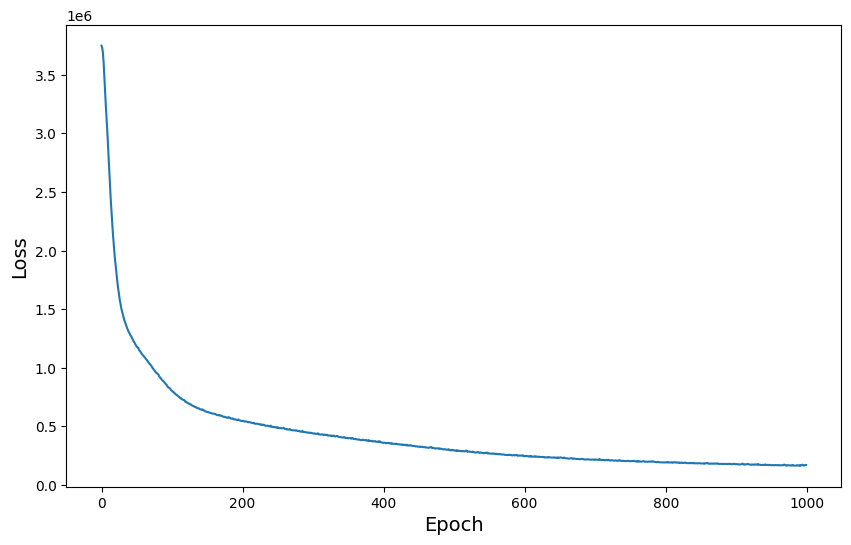

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(hist['loss'])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.savefig('learning_curve.jpg', dpi=300)

In [20]:
y_pred = model.predict(X_test)

69/69 [==============================] - 0s 2ms/step


In [21]:
y.shape

(14565, 1)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
from matplotlib.colorbar import ColorbarBase

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)
r2

0.9112955087185043

In [23]:
# Estimate point density using Gaussian KDE
xy = np.vstack([y_test.reshape(1,-1), y_pred.reshape(1,-1)])
z = gaussian_kde(xy)(xy)

C:\Software\Anaconda\Temp\ipykernel_9260\2597002093.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


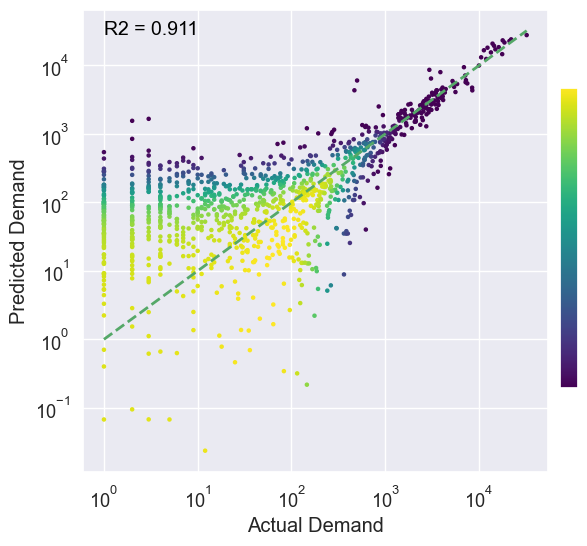

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
from matplotlib.colorbar import ColorbarBase

# Create the colormap
cmap = plt.cm.get_cmap('viridis')

# Create the scatter plot with the density-based color
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(y_test, y_pred, c=z, cmap=cmap, edgecolor=None, s=5)

cax = fig.add_axes([0.92, 0.25, 0.03, 0.5])
cb = ColorbarBase(cax, cmap=cmap, ticks=[])

# Set both axes to log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Add a regression line with a confidence interval
#sns.regplot(x=y_test, y=y_pred_test, scatter=False, ax=ax, ci=95, line_kws={'color': 'red', 'linewidth': 2, 'label': 'Regression Line'}, logx=True)

# Add the x=y line for comparison
x_y_line = np.logspace(np.log10(np.min(y_test)), np.log10(np.max(y_test)), 100)
ax.plot(x_y_line, x_y_line, 'g--', linewidth=2, label='')

# Annotate the plot with the R2 score
ax.text(np.min(y_test), np.max(y_pred), f'R2 = {r2:.3f}', fontsize=14, color='black')

# Add title, labels
#ax.set_title("R2 Plot with Color Density, Regression Line, and x=y Line for XGBoost Model", fontsize=16, pad=20)
ax.set_xlabel("Actual Demand")
ax.set_ylabel("Predicted Demand")

# Add the legend
#ax.legend(loc='best')

# Show the plot
plt.savefig('r2.jpg', dpi=300)

In [25]:
y_pred_final = model.predict(X)

456/456 [==============================] - 1s 2ms/step


In [26]:
demand = pd.concat([merged_df, pd.DataFrame(y_pred_final, columns=['prediction'])], axis=1)

In [27]:
selected_census_tracts = [48453001100, 48453000601, 48453000700]  # Add the Census Tract Start values to compare
filtered_data = demand[demand['Census Tract Start'].isin(selected_census_tracts)]

C:\Software\Anaconda\Temp\ipykernel_9260\3465886586.py:8: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=filtered_data, x='Hour', y='num_trips', hue='Census Tract Start', palette=palette, linestyle=':', linewidth=4, alpha=0.9, legend=False)
C:\Software\Anaconda\Temp\ipykernel_9260\3465886586.py:9: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=filtered_data, x='Hour', y='prediction', hue='Census Tract Start', palette=palette, linewidth=2, alpha=0.9, marker='o', dashes=False, legend='brief')


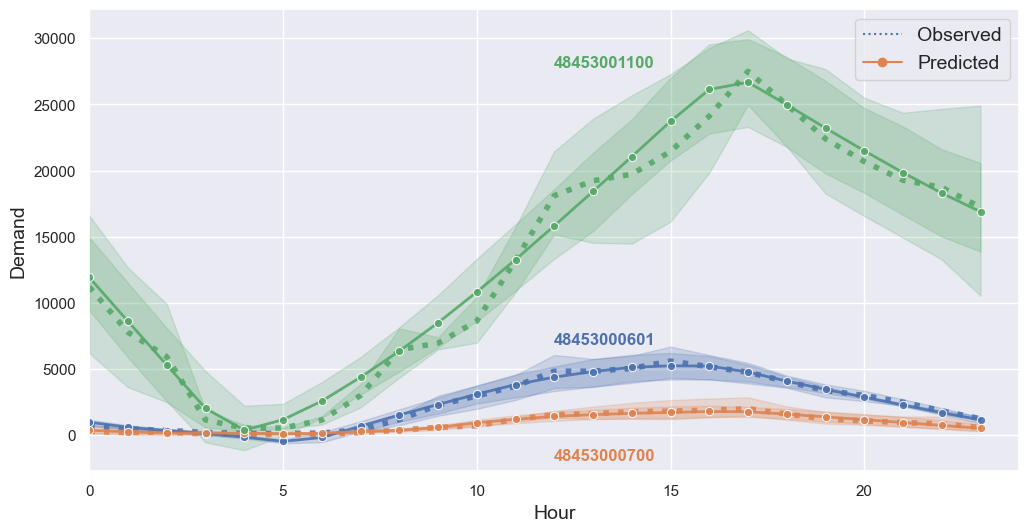

In [28]:
from matplotlib.lines import Line2D
palette = sns.color_palette()
observed_line = Line2D([], [], color=palette[0], label='Observed', linestyle=':')
predicted_line = Line2D([], [], color=palette[1], label='Predicted', marker='o')

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x='Hour', y='num_trips', hue='Census Tract Start', palette=palette, linestyle=':', linewidth=4, alpha=0.9, legend=False)
sns.lineplot(data=filtered_data, x='Hour', y='prediction', hue='Census Tract Start', palette=palette, linewidth=2, alpha=0.9, marker='o', dashes=False, legend='brief')

plt.xlabel('Hour', fontsize=14)
plt.ylabel('Demand', fontsize=14)
plt.xlim([0,24])
#plt.title('Demand by Hour for Selected Census Tract Starts', fontsize=16)
plt.legend(handles=[observed_line, predicted_line], fontsize=14)

plt.text(0.5, 0.9, "48453001100", transform=plt.gca().transAxes, fontsize=12, fontweight='bold', color = palette[2], va='top')
plt.text(0.5, 0.3, "48453000601", transform=plt.gca().transAxes, fontsize=12, fontweight='bold', color = palette[0], va='top')
plt.text(0.5, 0.05, "48453000700", transform=plt.gca().transAxes, fontsize=12, fontweight='bold', color = palette[1], va='top')
plt.savefig('demand_prediction.jpg', dpi=300)